In [5]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import dask.array as da
import xarray as xr
import string
import os

import cartopy as cart
import cartopy.crs as ccrs



from xmitgcm import open_mdsdataset
import xmitgcm
import sys
sys.path.append('/Users/tatsumonkman/3rd_party_software/ECCOv4-py')
import ecco_v4_py as ecco


from analysis_package import plotting_functions
from analysis_package import open_datasets
from analysis_package import ecco_masks

from importlib import reload

# reload modules for prototyping...
ecco_masks = reload(ecco_masks)
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


In [7]:
print(os.getcwd())

/Users/tatsumonkman/Dropbox/ECCO-Project/PUBLISH_ECCOv4r4_analysis_scripts


In [4]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [5]:
print(ecco.get_available_basin_names())

['pac', 'atl', 'ind', 'arct', 'bering', 'southChina', 'mexico', 'okhotsk', 'hudson', 'med', 'java', 'north', 'japan', 'timor', 'eastChina', 'red', 'gulf', 'baffin', 'gin', 'barents']


In [6]:
######################################################################################################################
################################################### LOAD GRID ########################################################
######################################################################################################################
grid_path = "./ECCO-GRID.nc"
grid = xr.open_dataset(grid_path)
cds = grid.coords.to_dataset()
grid_xmitgcm = ecco.ecco_utils.get_llc_grid(cds)

######################################################################################################################
############################################# CREATE DOMAIN MASKS ####################################################
######################################################################################################################
maskW = xr.open_dataarray("generic_masks/maskW.nc")
maskS = xr.open_dataarray("generic_masks/maskS.nc")
maskC = xr.open_dataarray("generic_masks/maskC.nc")

southern_ocean_mask_W, southern_ocean_mask_S, southern_ocean_mask_C, so_atl_basin_mask_W, so_atl_basin_mask_S, so_atl_basin_mask_C, so_indpac_basin_mask_W, so_indpac_basin_mask_S, so_indpac_basin_mask_C = ecco_masks.get_basin_masks(maskW, maskS, maskC)

baffin_mask_C = ecco.get_basin_mask("baffin",maskC)
north_mask_C = ecco.get_basin_mask("north",maskC)
hudson_mask_C = ecco.get_basin_mask("hudson",maskC)
gin_mask_C = ecco.get_basin_mask("gin",maskC)
bering_mask_C = ecco.get_basin_mask("bering",maskC)
okhotsk_mask_C = ecco.get_basin_mask("okhotsk",maskC)
atl_mask_C = ecco.get_basin_mask("atl",maskC)

atl_nogin_basin_mask_C = so_atl_basin_mask_C.where(so_atl_basin_mask_C.lat>-32,other=np.nan).where((gin_mask_C+north_mask_C < 1).values,other=np.nan)
indpac_basin_mask_C = so_indpac_basin_mask_C.where(so_indpac_basin_mask_C.lat>=-32,other=np.nan)
so_basin_mask_C = so_indpac_basin_mask_C.where(so_indpac_basin_mask_C.lat<-32,other=np.nan)



atl_midlat_basin_mask_C = so_atl_basin_mask_C.where(so_atl_basin_mask_C.lat<=50,other=np.nan).where(so_atl_basin_mask_C.lat>=-32,other=np.nan)



load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
load_binary_array: loading file /Users/tatsumonkman/3rd_party_software/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary

In [7]:
############################################################################################################
#####################    DEFINE CLASS FOR CONTOUR LEVELS, SIG2 PDENS LEVELS   ##############################
############################################################################################################

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


# Load Data

In [8]:
# Here I calculate the stretched y-axis coordinates on which to plot my stream functions. Defining them using the average
# depth of isopycnals in the Atlantic Ocean

AMOC_SIGMA2 = xr.open_dataarray("AMOC_sig2.nc").mean(dim="time")
IPMOC_SIGMA2 = xr.open_dataarray("IPMOC_sig2.nc").mean(dim="time")

dpth_lat_path = "./"
atl_pdens2_in_depth_lat = xr.open_dataarray(dpth_lat_path+"atl_SIGMA2_in_depth_lat.nc").mean(dim="time").loc[{"lat":np.arange(-32,35)}]
atl_pdens2_mean = grid.Z.assign_coords({"k":atl_pdens2_in_depth_lat.mean(dim="lat").values})
atl_pdens2_mean_lvls = atl_pdens2_mean.interp(k=AMOC_SIGMA2.sig[14:-5])
# extend atl_pdens2_mean_lvls to the ocean bottom
atl_pdens2_mean_lvls[-19:] = np.arange(-6000,atl_pdens2_mean_lvls[-20].values,81)[-1::-1]
# extend atl_pdens2_mean_lvls to the ocean bottom
atl_pdens2_mean_lvls[-19:] = np.arange(-11000,atl_pdens2_mean_lvls[-20].values,(11000 + atl_pdens2_mean_lvls[-20].values)/19)[-1::-1]


AMOC_smoothed = xr.open_dataarray("AMOC_sig2_smoothed.nc")
IPMOC_smoothed = xr.open_dataarray("IPMOC_sig2_smoothed.nc")


smoothed_atl_pdens2_mean_lvls = atl_pdens2_mean_lvls.interp(sig=AMOC_smoothed.sig)



min_potrho = 0
max_potrho = 48


########################################################################################################################################################################
########################################################################################################################################################################

amoc_botsurf_N = xr.open_dataarray("amoc_botsurf_N.nc")[:-2]
ipmoc_botsurf_N = xr.open_dataarray("ipmoc_botsurf_N.nc")[:-2]
amoc_botsurf_S = xr.open_dataarray("amoc_botsurf_S.nc")[:-2]
ipmoc_botsurf_S = xr.open_dataarray("ipmoc_botsurf_S.nc")[:-2]

amoc_N_interp = amoc_botsurf_N.interp(sig=AMOC_SIGMA2.sig)
amoc_S_interp = amoc_botsurf_S.interp(sig=AMOC_SIGMA2.sig)

ipmoc_N_interp = ipmoc_botsurf_N.interp(sig=AMOC_SIGMA2.sig)
ipmoc_S_interp = ipmoc_botsurf_S.interp(sig=AMOC_SIGMA2.sig)


#amoc_noSDS_botsurf = xr.open_dataarray("amoc_psi_botsurf_noSDS.nc")[70:]
########################################################################################################################################################################
########################################################################################################################################################################

amoc_botsurf_lvls = atl_pdens2_mean.interp(k=amoc_botsurf_N.sig)
ipmoc_botsurf_lvls = atl_pdens2_mean.interp(k=ipmoc_botsurf_N.sig)

########################################################################################################################################################################
########################################################################################################################################################################


# interpolate to fix bad sig

########################################################################################################################################################################
########################################################################################################################################################################

min_potrho = 0
max_potrho = 48

transports = xr.open_dataset("adv_diff_transports.nc").mean(dim="time").interp(sig=IPMOC_SIGMA2.sig)

indpac_tot_tendency = xr.open_dataarray("indpac_tot_tendency.nc").interp(sig=IPMOC_SIGMA2.sig)
atl_tot_tendency = xr.open_dataarray("atl_tot_tendency.nc").interp(sig=IPMOC_SIGMA2.sig)
so_tot_tendency = xr.open_dataarray("so_tot_tendency.nc").interp(sig=IPMOC_SIGMA2.sig)

indpac_diff_convergence = xr.open_dataarray("indpac_diff_convergence.nc").interp(sig=IPMOC_SIGMA2.sig)
atl_diff_convergence = xr.open_dataarray("atl_diff_convergence.nc").interp(sig=IPMOC_SIGMA2.sig)
so_diff_convergence = xr.open_dataarray("so_diff_convergence.nc").interp(sig=IPMOC_SIGMA2.sig)


SO_transports = xr.open_dataset("SO_transports.nc").interp(sig=IPMOC_SIGMA2.sig)
########################################################################################################################################################################
########################################################################################################################################################################


ip_sig2_total_advconvergence = xr.open_dataarray("ip_sig2_total_advconvergence_FINAL.nc").sum(dim=["tile","i","j"]).interp(sig=AMOC_SIGMA2.sig)[14:-5]
ip_sig2_total_difconvergence = xr.open_dataarray("ip_sig2_total_difconvergence_FINAL.nc").sum(dim=["tile","i","j"]).interp(sig=AMOC_SIGMA2.sig)[14:-5]

atl_sig2_total_advconvergence = xr.open_dataarray("atl_sig2_total_advconvergence_FINAL.nc").sum(dim=["tile","i","j"]).interp(sig=AMOC_SIGMA2.sig)[14:-5]
atl_sig2_total_difconvergence = xr.open_dataarray("atl_sig2_total_difconvergence_FINAL.nc").sum(dim=["tile","i","j"]).interp(sig=AMOC_SIGMA2.sig)[14:-5]

atl_sig2_total_advconvergence.loc[{"sig":atl_sig2_total_advconvergence.sig[40:]}] = 0
atl_sig2_total_difconvergence.loc[{"sig":atl_sig2_total_difconvergence.sig[40:]}] = 0


so_sig2_total_advconvergence = xr.open_dataarray("so_sig2_total_advconvergence_FINAL.nc").sum(dim=["tile","i","j"]).interp(sig=AMOC_SIGMA2.sig)[14:-5]
so_sig2_total_difconvergence = xr.open_dataarray("so_sig2_total_difconvergence_FINAL.nc").sum(dim=["tile","i","j"]).interp(sig=AMOC_SIGMA2.sig)[14:-5]


dFgeo2_drho_indpac = xr.open_dataarray("dFgeo2_drho_indpac_FINAL.nc").interp(sig=AMOC_SIGMA2.sig)[14:-5]
dFgeo2_drho_atl = xr.open_dataarray("dFgeo2_drho_atl_FINAL.nc").interp(sig=AMOC_SIGMA2.sig)[14:-5]
dFgeo2_drho_so = xr.open_dataarray("dFgeo2_drho_so_FINAL.nc").interp(sig=AMOC_SIGMA2.sig)[14:-5]


ip_dvol_dt = xr.open_dataarray("ip_dvol_dt_FINAL.nc").interp(sig=AMOC_SIGMA2.sig)[14:-5]
atl_dvol_dt = xr.open_dataarray("atl_dvol_dt_FINAL.nc").interp(sig=AMOC_SIGMA2.sig)[14:-5]
so_dvol_dt = xr.open_dataarray("so_dvol_dt_FINAL.nc").interp(sig=AMOC_SIGMA2.sig)[14:-5]

In [9]:
########################################################################################################################################################################
########################################################################################################################################################################
ds = 180*50*24*60*60

suffix = "_high_res"

ip_sig2_total_advconvergence_highres = xr.open_dataarray(f"ip_sig2_total_advconvergence_FINAL{suffix}.nc").sum(dim=["tile","i","j"])
ip_sig2_total_difconvergence_highres = xr.open_dataarray(f"ip_sig2_total_difconvergence_FINAL{suffix}.nc").sum(dim=["tile","i","j"])

atl_sig2_total_advconvergence_highres = xr.open_dataarray(f"atl_sig2_total_advconvergence_FINAL{suffix}.nc").sum(dim=["tile","i","j"])
atl_sig2_total_difconvergence_highres = xr.open_dataarray(f"atl_sig2_total_difconvergence_FINAL{suffix}.nc").sum(dim=["tile","i","j"])

so_sig2_total_advconvergence_highres = xr.open_dataarray(f"so_sig2_total_advconvergence_FINAL{suffix}.nc").sum(dim=["tile","i","j"])
so_sig2_total_difconvergence_highres = xr.open_dataarray(f"so_sig2_total_difconvergence_FINAL{suffix}.nc").sum(dim=["tile","i","j"])

ip_dvol_dt_highres = xr.open_dataarray(f"ip_dvol_dt{suffix}.nc")/ds
so_dvol_dt_highres = xr.open_dataarray(f"so_dvol_dt{suffix}.nc")/ds
atl_dvol_dt_highres = xr.open_dataarray(f"atl_dvol_dt{suffix}.nc")/ds

so_T_forcS_highres = xr.open_dataarray(f"so_T_forcSALT{suffix}.nc")
atl_T_forcS_highres = xr.open_dataarray(f"atl_T_forcSALT{suffix}.nc")
ip_T_forcS_highres = xr.open_dataarray(f"ip_T_forcSALT{suffix}.nc")


dFgeo2_drho_ip_highres = xr.open_dataarray(f"dFgeo2_drho_indpac{suffix}.nc")
dFgeo2_drho_so_highres = xr.open_dataarray(f"dFgeo2_drho_so{suffix}.nc")
dFgeo2_drho_atl_highres= xr.open_dataarray(f"dFgeo2_drho_atl{suffix}.nc")


In [10]:
prefix = "."
ATL_sig_mask = xr.open_dataarray("ATL_sig_mask.nc")
indpac_basin_mask_C

T_TH_advection_tmean = xr.open_dataarray(f"{prefix}/T_TH_advection_tmean.nc")
T_TH_diffusion_tmean = xr.open_dataarray(f"{prefix}/T_TH_diffusion_tmean.nc")
T_TH_SWforcing_tmean = xr.open_dataarray(f"{prefix}/T_TH_SWforcing_tmean.nc")
T_TH_GEOforcing_tmean = xr.open_dataarray(f"{prefix}/T_TH_GEOforcing_tmean.nc")
T_TH_tendency_tmean = xr.open_dataarray(f"{prefix}/T_TH_tendency_tmean.nc")

T_SLT_advection_tmean = xr.open_dataarray(f"{prefix}/T_SLT_advection_tmean.nc")
T_SLT_diffusion_tmean = xr.open_dataarray(f"{prefix}/T_SLT_diffusion_tmean.nc")
T_SLT_forcing_tmean = xr.open_dataarray(f"{prefix}/T_SLT_forcing_tmean.nc")
T_SLT_tendency_tmean = xr.open_dataarray(f"{prefix}/T_SLT_tendency_tmean.nc")


SIGMA2 = xr.open_dataarray(f"Mixing_Diags/SIGMA2_full.nc")
SIGMA2_k0_tmax = (SIGMA2.isel(k=0).max(dim="time").assign_coords(maskC.coords)*maskC)
SIGMA2_k0_tmax_SH = SIGMA2_k0_tmax.where(SIGMA2_k0_tmax.lat <= -20, other=np.nan)
SIGMA2.close()
SO_sig2_mask_highres = T_TH_advection_tmean
# make a blank mask of 1's
blank_mask = SO_sig2_mask_highres*0+1
SO_sig_mask = blank_mask.copy()

for lat in np.arange(-88,-20):
    SIGMA2_k0_tmax_SH_tmp = SIGMA2_k0_tmax_SH.where(maskC.assign_coords(tile=np.arange(0,13)).lat >= lat,other=np.nan).copy()
    sig_max = SIGMA2_k0_tmax_SH_tmp.max()

    tmp_mask = blank_mask.copy()*0
    tmp_mask = tmp_mask.where(tmp_mask.sig <= sig_max, other=np.nan)
    tmp_mask = tmp_mask.where(maskC.assign_coords(tile=np.arange(0,13)).lat.lat < lat, other=np.nan)
    tmp_mask = tmp_mask.fillna(1)
    
    SO_sig_mask = SO_sig_mask*tmp_mask





# Concatenate high and lowres datasets

In [11]:

ip_dvol_dt_full = xr.concat([ip_dvol_dt[:28],
                             ip_dvol_dt_highres,
                             ip_dvol_dt[-10:]],dim="sig",coords="minimal")
so_dvol_dt_full = xr.concat([so_dvol_dt[:28],
                             so_dvol_dt_highres,
                             so_dvol_dt[-10:]],dim="sig",coords="minimal")
atl_dvol_dt_full = xr.concat([atl_dvol_dt[:28],
                             atl_dvol_dt_highres,
                             atl_dvol_dt[-10:]],dim="sig",coords="minimal")


ip_sig2_total_advconvergence_full = xr.concat([ip_sig2_total_advconvergence[:28],
                                                 ip_sig2_total_advconvergence_highres,
                                                 ip_sig2_total_advconvergence[-10:]],dim="sig",coords="minimal").interp(sig=ip_dvol_dt_full.sig)
so_sig2_total_advconvergence_full = xr.concat([so_sig2_total_advconvergence[:28],
                                                 so_sig2_total_advconvergence_highres,
                                                 so_sig2_total_advconvergence[-10:]],dim="sig",coords="minimal").interp(sig=ip_dvol_dt_full.sig)
atl_sig2_total_advconvergence_full = xr.concat([atl_sig2_total_advconvergence[:28],
                                                 atl_sig2_total_advconvergence_highres,
                                                 atl_sig2_total_advconvergence[-10:]],dim="sig",coords="minimal").interp(sig=ip_dvol_dt_full.sig)

ip_sig2_total_difconvergence_full = xr.concat([ip_sig2_total_difconvergence[:28],
                                                 ip_sig2_total_difconvergence_highres,
                                                 ip_sig2_total_difconvergence[-10:]],dim="sig",coords="minimal")#\.interp(sig=ip_dvol_dt_full.sig)
so_sig2_total_difconvergence_full = xr.concat([so_sig2_total_difconvergence[:28],
                                                 so_sig2_total_difconvergence_highres,
                                                 so_sig2_total_difconvergence[-10:]],dim="sig",coords="minimal").interp(sig=ip_dvol_dt_full.sig)
atl_sig2_total_difconvergence_full = xr.concat([atl_sig2_total_difconvergence[:28],
                                                 atl_sig2_total_difconvergence_highres,
                                                 atl_sig2_total_difconvergence[-10:]],dim="sig",coords="minimal").interp(sig=ip_dvol_dt_full.sig)

dFgeo2_drho_indpac_full = xr.concat([dFgeo2_drho_indpac.mean(dim="time")[:42],
                                       dFgeo2_drho_ip_highres,
                                       dFgeo2_drho_indpac.mean(dim="time")[-15:]],dim="sig",coords="minimal").interp(sig=atl_sig2_total_difconvergence_full.sig)
dFgeo2_drho_atl_full = xr.concat([dFgeo2_drho_atl.mean(dim="time")[:42],
                                   dFgeo2_drho_atl_highres,
                                   dFgeo2_drho_atl.mean(dim="time")[-15:]],dim="sig",coords="minimal").interp(sig=atl_sig2_total_difconvergence_full.sig)
dFgeo2_drho_so_full = xr.concat([dFgeo2_drho_so.mean(dim="time")[:42],
                                   dFgeo2_drho_so_highres,
                                   dFgeo2_drho_so.mean(dim="time")[-15:]],dim="sig",coords="minimal").interp(sig=atl_sig2_total_difconvergence_full.sig)


so_T_forcS_highres_full = so_T_forcS_highres.interp(sig=atl_dvol_dt_full.sig)
atl_T_forcS_highres_full = atl_T_forcS_highres.interp(sig=atl_dvol_dt_full.sig)
ip_T_forcS_highre_fulls = ip_T_forcS_highres.interp(sig=atl_dvol_dt_full.sig)


# modify stretched coordinates
atl_pdens2_mean_lvls_full = atl_pdens2_mean_lvls.interp(sig=atl_dvol_dt_full.sig)




In [12]:


    
atl_T_TH_advection_tmean = (T_TH_advection_tmean*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
atl_T_TH_diffusion_tmean = (T_TH_diffusion_tmean*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
atl_T_TH_SWforcing_tmean = (T_TH_SWforcing_tmean*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
atl_T_TH_GEOforcing_tmean = (T_TH_GEOforcing_tmean*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
atl_T_TH_tendency_tmean = (T_TH_tendency_tmean*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)

atl_T_SLT_advection_tmean = (T_SLT_advection_tmean*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
atl_T_SLT_diffusion_tmean = (T_SLT_diffusion_tmean*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
atl_T_SLT_forcing_tmean = (T_SLT_forcing_tmean*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
atl_T_SLT_tendency_tmean = (T_SLT_tendency_tmean*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)


so_T_TH_advection_tmean = (T_TH_advection_tmean*SO_sig_mask*so_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
so_T_TH_diffusion_tmean = (T_TH_diffusion_tmean*SO_sig_mask*so_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
so_T_TH_SWforcing_tmean = (T_TH_SWforcing_tmean*SO_sig_mask*so_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
so_T_TH_GEOforcing_tmean = (T_TH_GEOforcing_tmean*SO_sig_mask*so_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
so_T_TH_tendency_tmean = (T_TH_tendency_tmean*SO_sig_mask*so_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)

so_T_SLT_advection_tmean = (T_SLT_advection_tmean*SO_sig_mask*so_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
so_T_SLT_diffusion_tmean = (T_SLT_diffusion_tmean*SO_sig_mask*so_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
so_T_SLT_forcing_tmean = (T_SLT_forcing_tmean*SO_sig_mask*so_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
so_T_SLT_tendency_tmean = (T_SLT_tendency_tmean*SO_sig_mask*so_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)


ip_T_TH_advection_tmean = (T_TH_advection_tmean*indpac_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
ip_T_TH_diffusion_tmean = (T_TH_diffusion_tmean*indpac_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
ip_T_TH_SWforcing_tmean = (T_TH_SWforcing_tmean*indpac_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
ip_T_TH_GEOforcing_tmean = (T_TH_GEOforcing_tmean*indpac_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
ip_T_TH_tendency_tmean = (T_TH_tendency_tmean*indpac_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)

ip_T_SLT_advection_tmean = (T_SLT_advection_tmean*indpac_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
ip_T_SLT_diffusion_tmean = (T_SLT_diffusion_tmean*indpac_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
ip_T_SLT_forcing_tmean = (T_SLT_forcing_tmean*indpac_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)
ip_T_SLT_tendency_tmean = (T_SLT_tendency_tmean*indpac_basin_mask_C).sum(dim=["tile","j","i"]).interp(sig=ip_dvol_dt_full.sig)




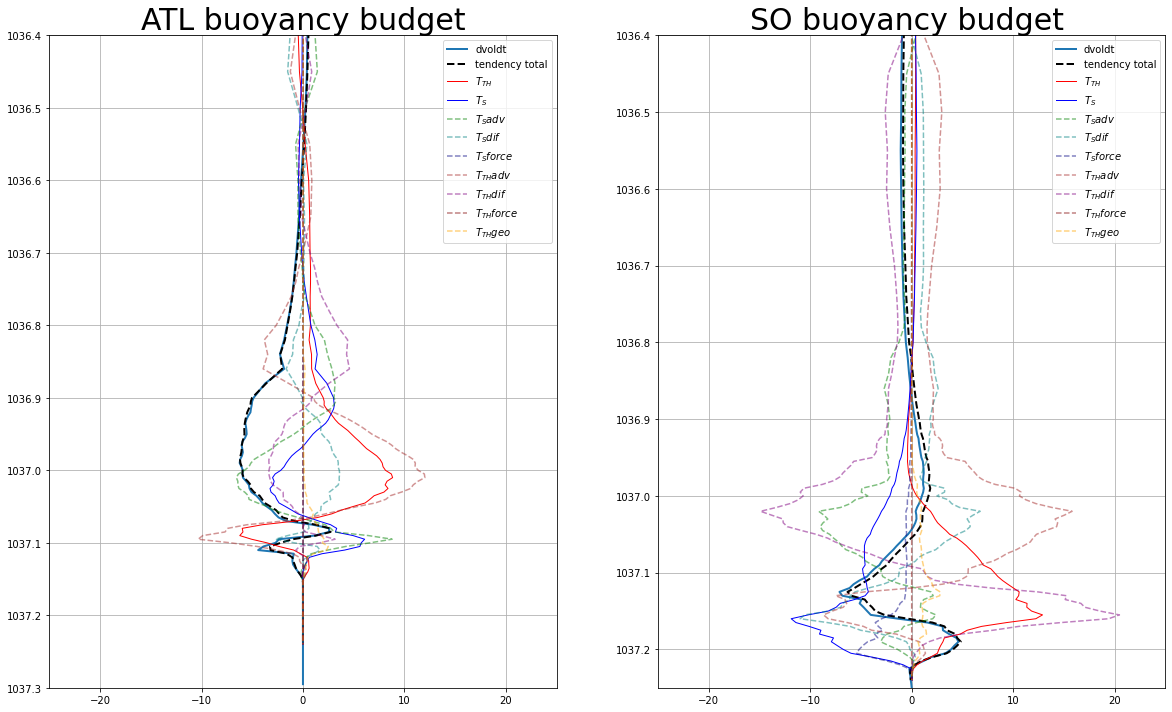

In [13]:
fig, axs = plt.subplots(1,2,figsize=(20,12))


axs[0].plot(atl_dvol_dt_full/1e6,atl_dvol_dt_full.sig,label="dvoldt",linewidth=2)

axs[0].plot(- atl_T_TH_tendency_tmean/1e6  - atl_T_SLT_tendency_tmean/1e6, atl_T_SLT_tendency_tmean.sig,label="tendency total",linestyle="--",color="black",linewidth=2)
axs[0].plot(atl_T_TH_tendency_tmean/1e6, atl_T_SLT_tendency_tmean.sig,label="$T_{TH}$",color="red",linewidth=1)
axs[0].plot(atl_T_SLT_tendency_tmean/1e6, atl_T_SLT_tendency_tmean.sig,label="$T_{S}$",color="blue",linewidth=1)

axs[0].plot(atl_T_SLT_advection_tmean/1e6,atl_T_SLT_advection_tmean.sig,label="$T_{S}adv$",linestyle="--",color="green",alpha=0.5)
axs[0].plot(atl_T_SLT_diffusion_tmean/1e6,atl_T_SLT_diffusion_tmean.sig,label="$T_{S}dif$",linestyle="--",color="teal",alpha=0.5)
axs[0].plot(atl_T_SLT_forcing_tmean/1e6,atl_T_SLT_forcing_tmean.sig,label="$T_{S}force$",linestyle="--",color="navy",alpha=0.5)

axs[0].plot(atl_T_TH_advection_tmean/1e6,atl_T_TH_advection_tmean.sig,label="$T_{TH}adv$",linestyle="--",color="brown",alpha=0.5)
axs[0].plot(atl_T_TH_diffusion_tmean/1e6,atl_T_TH_diffusion_tmean.sig,label="$T_{TH}dif$",linestyle="--",color="purple",alpha=0.5)
axs[0].plot(atl_T_TH_SWforcing_tmean/1e6,atl_T_TH_SWforcing_tmean.sig,label="$T_{TH}force$",linestyle="--",color="maroon",alpha=0.5)
axs[0].plot(atl_T_TH_GEOforcing_tmean/1e6,atl_T_TH_GEOforcing_tmean.sig,label="$T_{TH}geo$",linestyle="--",color="orange",alpha=0.5)




axs[1].plot(so_dvol_dt_full/1e6,so_dvol_dt_full.sig,label="dvoldt",linewidth=2)

axs[1].plot(- so_T_TH_tendency_tmean/1e6  - so_T_SLT_tendency_tmean/1e6, so_T_SLT_tendency_tmean.sig,label="tendency total",linestyle="--",color="black",linewidth=2)
axs[1].plot(so_T_TH_tendency_tmean/1e6, so_T_SLT_tendency_tmean.sig,label="$T_{TH}$",color="red",linewidth=1)
axs[1].plot(so_T_SLT_tendency_tmean/1e6, so_T_SLT_tendency_tmean.sig,label="$T_{S}$",color="blue",linewidth=1)

axs[1].plot(so_T_SLT_advection_tmean/1e6,so_T_SLT_advection_tmean.sig,label="$T_{S}adv$",linestyle="--",color="green",alpha=0.5)
axs[1].plot(so_T_SLT_diffusion_tmean/1e6,so_T_SLT_diffusion_tmean.sig,label="$T_{S}dif$",linestyle="--",color="teal",alpha=0.5)
axs[1].plot(so_T_SLT_forcing_tmean/1e6,so_T_SLT_forcing_tmean.sig,label="$T_{S}force$",linestyle="--",color="navy",alpha=0.5)

axs[1].plot(so_T_TH_advection_tmean/1e6,so_T_TH_advection_tmean.sig,label="$T_{TH}adv$",linestyle="--",color="brown",alpha=0.5)
axs[1].plot(so_T_TH_diffusion_tmean/1e6,so_T_TH_diffusion_tmean.sig,label="$T_{TH}dif$",linestyle="--",color="purple",alpha=0.5)
axs[1].plot(so_T_TH_SWforcing_tmean/1e6,so_T_TH_SWforcing_tmean.sig,label="$T_{TH}force$",linestyle="--",color="maroon",alpha=0.5)
axs[1].plot(so_T_TH_GEOforcing_tmean/1e6,so_T_TH_GEOforcing_tmean.sig,label="$T_{TH}geo$",linestyle="--",color="orange",alpha=0.5)



axs[0].set_title("ATL buoyancy budget",fontsize=30)
axs[0].set_ylim(1037.3,1036.4)
axs[0].set_xlim(-25,25)
axs[0].grid()
axs[0].legend()

axs[1].set_title("SO buoyancy budget ",fontsize=30)
axs[1].set_ylim(1037.25,1036.4)
axs[1].set_xlim(-25,25)
axs[1].grid()
axs[1].legend()

plt.show()
plt.close()

In [14]:
tend_atl_pdens2_mean_lvls = atl_pdens2_mean_lvls.interp(sig=atl_T_TH_diffusion_tmean.sig)

In [15]:
atl_sig2_total_advconvergence_full[76:] = 0
atl_sig2_total_difconvergence_full[76:] = 0

In [16]:
SO_adv_total = SO_transports.so_th_totaladv.mean(dim="time") + SO_transports.so_slt_totaladv.mean(dim="time")
SO_diff_total = SO_transports.so_th_totaldiff.mean(dim="time") + SO_transports.so_slt_totaldiff.mean(dim="time")

In [17]:

psis_bottom_of_surf = xr.open_dataset("psis_bottom_of_surf.nc")
vol_psi_ds = xr.open_dataset("vol_psi_ds.nc")

In [18]:

########################################################################################################################################################################
########################################################################################################################################################################

########################################################################################################################################################################
########################################################################################################################################################################

########################################################################################################################################################################
########################################################################################################################################################################


dVdtcolor="#1f77b4"
fGeocolor="blueviolet"
D_Psicolor="k"
Dmixcolor="r"
ipcolor = "#0400BB"
acolor = "#0400BB"
gcolor = "#0400BB"
component_alpha = 0.7


Psi1_color="k"
Psi2_color="grey"#"#00C0FF"
psi1alpha=0.3
psi2alpha=1

Psi_linestyle="dashed"
Psi_linewidth=3

budget_linestyle="solid"
budget_linewidth=2

In [19]:
vol_psi_merged = xr.open_dataset("vol_psi_merged.nc")

In [20]:
tick_locs = [0,5,12,16,23,28,31,33,34,35,37,38,39,40,41,42,43,44,45]
ytick_locs = atl_pdens2_mean_lvls[tick_locs]
ytick_vals = np.around(vol_psi_merged.sig[tick_locs].values,2)
ytick_locs = np.concatenate((ytick_locs[:-13],[-2098.61725537,-2352.53869657],ytick_locs[-12:-9],
                             [-3322,(ytick_locs[9]+ytick_locs[10])/2],
                             [ytick_locs[-9]],
                             [(ytick_locs[10]+ytick_locs[11])/2],
                             ytick_locs[-9:])) 
ytick_vals = np.concatenate((ytick_vals[:-13],[1036.95,1036.98],ytick_vals[-12:-9],
                             [1037.053,1037.06],
                             [ytick_vals[-9]],
                             [1037.09],
                             ytick_vals[-9:]))


In [21]:
atl_total_diff = transports.atl_th_totaldiff + transports.atl_slt_totaldiff
atl_total_adv = transports.atl_th_totaladv + transports.atl_slt_totaladv
indpac_total_diff = transports.indpac_th_totaldiff + transports.indpac_slt_totaldiff
indpac_total_adv = transports.indpac_th_totaladv + transports.indpac_slt_totaladv
so_total_diff = transports.so_th_totaldiff + transports.so_slt_totaldiff
so_total_adv = transports.so_th_totaladv + transports.so_slt_totaladv

In [22]:
atl_total_adv[54:] = 0
atl_total_diff[54:] = 0

In [23]:
dFgeo2_drho_indpac = xr.open_dataarray("dFgeo2_drho_indpac_FINAL.nc")
dFgeo2_drho_atl = xr.open_dataarray("dFgeo2_drho_atl_FINAL.nc")
dFgeo2_drho_so = xr.open_dataarray("dFgeo2_drho_so_FINAL.nc")



In [24]:
SO_bottom_surf_da = xr.open_dataarray("SO_bottom_surf_da_September.nc")


SO_bottom_surf_da = xr.concat([SO_bottom_surf_da[14:39],
                               SO_bottom_surf_da[39]*0+SO_bottom_surf_da[39:45].mean().values,
                               SO_bottom_surf_da[45]*0+SO_bottom_surf_da[45:47].mean().values,
                               SO_bottom_surf_da[47:51],
                               SO_bottom_surf_da[51]*0+SO_bottom_surf_da[51:55].mean().values,
                               SO_bottom_surf_da[55]*0+SO_bottom_surf_da[55:58].mean().values,
                               SO_bottom_surf_da[58:-2]
                              ],dim="sig")



In [25]:
NA_bottom_surf_da = xr.open_dataarray("NA_bottom_surf_da_September.nc")[::-1]

NA_bottom_surf_da = xr.concat([NA_bottom_surf_da[14],
                              NA_bottom_surf_da[15]*0+NA_bottom_surf_da[15:18].mean().values,
                              NA_bottom_surf_da[18:22],
                              NA_bottom_surf_da[22]*0+NA_bottom_surf_da[22:28].mean().values,
                              NA_bottom_surf_da[28:35],
                              NA_bottom_surf_da[35]*0+NA_bottom_surf_da[35:37].mean().values,
                              NA_bottom_surf_da[37:41],
                              NA_bottom_surf_da[41]*0+NA_bottom_surf_da[41:43].mean().values,
                              NA_bottom_surf_da[43],
                              NA_bottom_surf_da[44]*0+NA_bottom_surf_da[44:46].mean().values,
                              NA_bottom_surf_da[46:]
                              ],dim="sig")

NA_bottom_surf_da = NA_bottom_surf_da.where(NA_bottom_surf_da.sig<1036.98,other=0)

In [26]:
print(float((AMOC_smoothed.loc[{"lat":-32}]/1e6).interp(sig=1036.95).values))
float((AMOC_smoothed.loc[{"lat":-32}]/1e6).interp(sig=1036.6).values)

9.56792202777367


14.199826822506543

atl NADW formation 1036.95: 1.4762553512144738
atl NADW formation 1036.6: 15.359901001199969
atl num 1036.6: 2.195684099073092
atl mix 1036.6: -0.864605122439343
atl dVdt 1036.6: -0.1867361237835762
atl D_Psi_surf 1036.6: 1.1600741786934259

atl num 1036.95: -2.5528844607176793
atl mix 1036.95: -0.24630041600214472
atl dVdt 1036.95: -5.5493971237810005
atl D_Psi_surf 1036.95: -8.091666676559198

ip num 1036.6: -1.0603151000466662
ip mix 1036.6: 5.043326206445684
ip f_geo 1036.6: 0.03811623411650433
ip dVdt 1036.6: -2.097486683858432
ip D_Psi_surf 1036.6: 1.9656828592072177

ip num 1036.95: 2.4655949493825315
ip mix 1036.95: 2.2236648569637776
ip f_geo 1036.95: 0.7982158862697076
ip dVdt 1036.95: 4.2849217931130354
ip D_Psi_surf 1036.95: 9.701765160863657

ip num 1037.053: -8.020395009495983
ip mix 1037.053: 0.23796515531535428
ip f_geo 1037.053: 3.286318563859609
ip dVdt 1037.053: 17.115547031104448
ip D_Psi_surf 1037.053: 14.429218170961567

ip num 1037.095: 6.357387425684844


so num

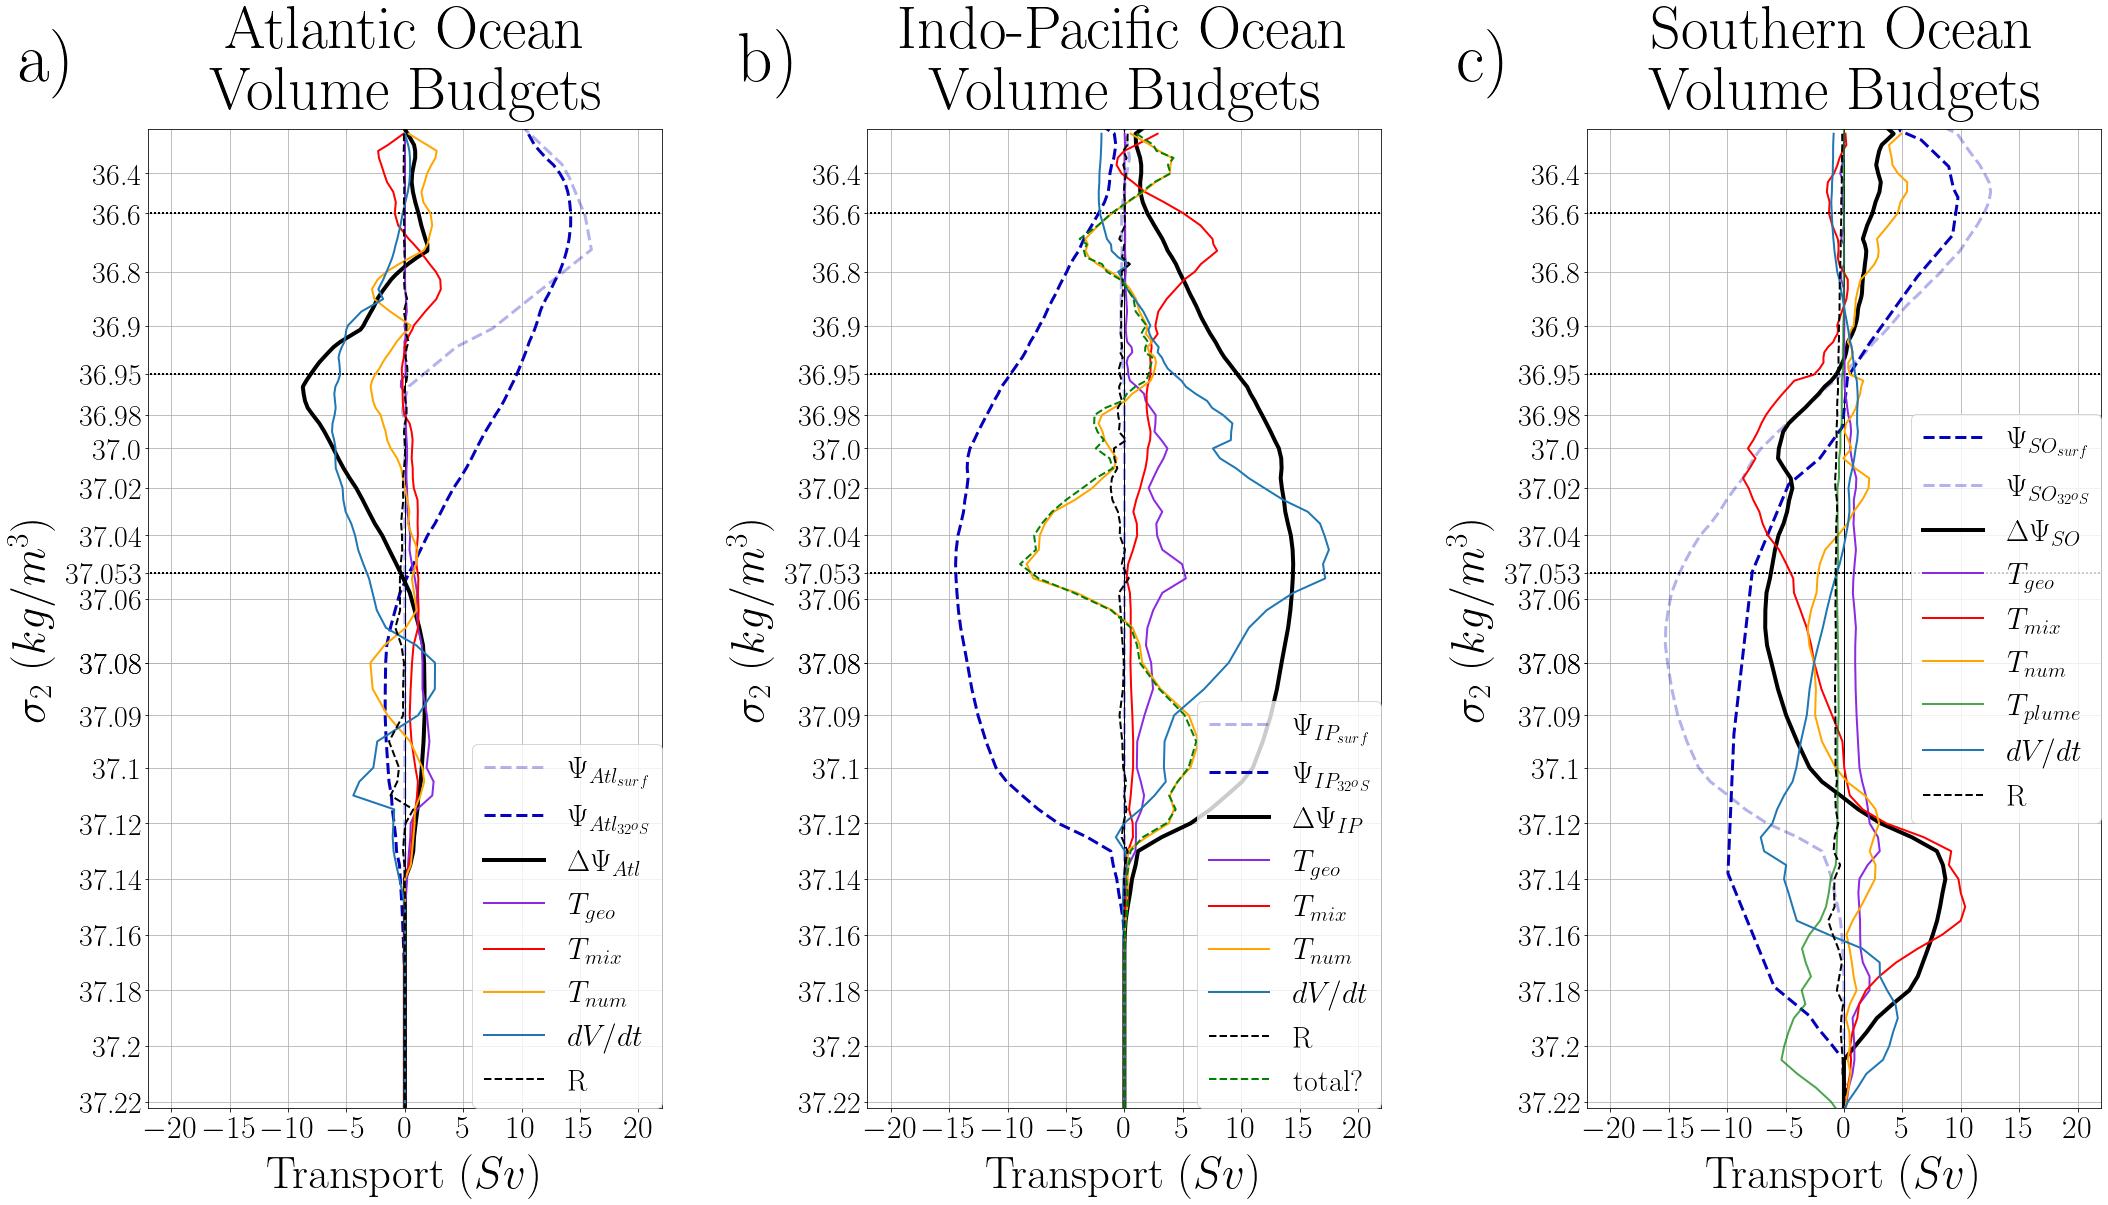

In [27]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')



########################################################################################################################################################################
########################################################################################################################################################################

fig = plt.figure(figsize=(35,18),
                 #dpi=300
                )
gs = gridspec.GridSpec(nrows=1,ncols=3,wspace=0.4)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
axs = [ax0,ax1,ax2]
pdens_yticks=True





######################
# Atlantic #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32

amoc_N_interp_60 = psis_bottom_of_surf.amoc_N.where(psis_bottom_of_surf.amoc_N.sig2 < 1037.05,other=0)
Psi_atl_S = (AMOC_SIGMA2.loc[{"lat":s_lat}])[14:-5]/1e6       
D_Psi_surf = (NA_bottom_surf_da.interp(sig=AMOC_smoothed.sig)/1e6-AMOC_smoothed.loc[{"lat":-32}]/1e6).fillna(0)


DN = (D_Psi_surf.interp(sig=atl_pdens2_mean_lvls_full.sig) 
      + atl_sig2_total_advconvergence_full/1e6
      )

RESIDUAL = ( 
            - atl_sig2_total_advconvergence_full/1e6
            - atl_dvol_dt_full/1e6
            - dFgeo2_drho_atl_full/1e6 
            - atl_sig2_total_difconvergence_full/1e6
           )

print(f"atl NADW formation 1036.95: {(NA_bottom_surf_da.interp(sig=AMOC_smoothed.sig)/1e6).interp(sig=1036.95).values}")
print(f"atl NADW formation 1036.6: {(NA_bottom_surf_da.interp(sig=AMOC_smoothed.sig)/1e6).interp(sig=1036.6).values}")


print(f"atl num 1036.6: {DN.interp(sig=1036.6).values}")
print(f"atl mix 1036.6: {atl_sig2_total_difconvergence_full.interp(sig=1036.6).values/1e6}")
#print(f"atl f_geo 1036.6: {dFgeo2_drho_atl_full.interp(sig=1036.6).values}")
print(f"atl dVdt 1036.6: {atl_dvol_dt_full.interp(sig=1036.6).values/1e6}")
print(f"atl D_Psi_surf 1036.6: {D_Psi_surf.interp(sig=1036.6).values}\n")

print(f"atl num 1036.95: {DN.interp(sig=1036.95).values}")
print(f"atl mix 1036.95: {atl_sig2_total_difconvergence_full.interp(sig=1036.95).values/1e6}")
#print(f"atl f_geo 1036.95: {f_geo.interp(sig=1036.95).values}")
print(f"atl dVdt 1036.95: {atl_dvol_dt_full.interp(sig=1036.95).values/1e6}")


print(f"atl D_Psi_surf 1036.95: {D_Psi_surf.interp(sig=1036.95).values}\n")


ax0.plot(NA_bottom_surf_da/1e6,atl_pdens2_mean_lvls.interp(sig=NA_bottom_surf_da.sig),
         label="$\Psi_{Atl_{surf}}$",linewidth=Psi_linewidth,color=gcolor,linestyle=Psi_linestyle,alpha=psi1alpha)

# ax0.plot(Psi_atl_S,atl_pdens2_mean_lvls,
#          label="$\Psi_{Atl_{32^{o}S}}$",linewidth=Psi_linewidth,color=gcolor,linestyle=Psi_linestyle,alpha=psi2alpha)

ax0.plot(AMOC_smoothed.loc[{"lat":-32}]/1e6,smoothed_atl_pdens2_mean_lvls,
        label="$\Psi_{Atl_{32^{o}S}}$",linewidth=Psi_linewidth,color=gcolor,linestyle=Psi_linestyle,alpha=psi2alpha)

#ax0.plot(atl_sig2_total_advconvergence_full/1e6,atl_pdens2_mean_lvls_full,
#         label="$T_{adv}$",linewidth=2,color="blue",linestyle="--",alpha=component_alpha)



ax0.plot(D_Psi_surf,smoothed_atl_pdens2_mean_lvls,
         label="$\Delta\Psi_{Atl}$",linewidth=4,color=D_Psicolor)
ax0.plot(dFgeo2_drho_atl_full/1e6,atl_pdens2_mean_lvls_full,
         label="$T_{geo}$",linewidth=budget_linewidth,color=fGeocolor,linestyle=budget_linestyle)
# diagnosed diffusive convergence
ax0.plot(atl_sig2_total_difconvergence_full/1e6,atl_pdens2_mean_lvls_full,
         label="$T_{mix}$",linewidth=budget_linewidth,color=Dmixcolor,linestyle=budget_linestyle)
ax0.plot(DN,atl_pdens2_mean_lvls_full,
        label="$T_{num}$",linestyle=budget_linestyle,linewidth=2,color="orange")

ax0.plot(atl_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=budget_linewidth,linestyle=budget_linestyle,color=dVdtcolor)

# Residual
ax0.plot(atl_dvol_dt_full/1e6 
         + atl_T_TH_tendency_tmean.interp(sig=atl_dvol_dt_full.sig)/1e6 
         + atl_T_SLT_tendency_tmean.interp(sig=atl_dvol_dt_full.sig)/1e6, 
         atl_pdens2_mean_lvls_full, color="k",linewidth=2,linestyle="--",label="R")



######################
# Indo-Pacific #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32 

Psi_ip_S = (IPMOC_SIGMA2.loc[{"lat":s_lat}])[14:-5]/1e6       
f_geo = (dFgeo2_drho_indpac.mean(dim="time")/1e6).interp(sig=Psi_atl_S.sig)
D_Psi_surf = (ipmoc_N_interp[14:-5].interp(sig=IPMOC_smoothed.sig)/1e6-IPMOC_smoothed.loc[{"lat":-32}]/1e6).fillna(0)
DN = (D_Psi_surf.interp(sig=atl_pdens2_mean_lvls_full.sig) 
        + ip_sig2_total_advconvergence_full/1e6
        #- ip_dvol_dt_full/1e6
        #- dFgeo2_drho_indpac_full/1e6 
        #- ip_sig2_total_difconvergence_full/1e6
       )

RESIDUAL = ( 
            - so_sig2_total_advconvergence_full/1e6
            - so_dvol_dt_full/1e6
            - dFgeo2_drho_so_full/1e6
            - so_sig2_total_difconvergence_full/1e6
            - so_T_forcS_highres_full.sum(dim=["tile","j","i"])/1e6
           )

RESIDUAL = (
            - ip_sig2_total_advconvergence_full/1e6
            - ip_dvol_dt_full/1e6
            - dFgeo2_drho_indpac_full/1e6 
            - ip_sig2_total_difconvergence_full/1e6
           )

print(f"ip num 1036.6: {DN.interp(sig=1036.6).values}")
print(f"ip mix 1036.6: {ip_sig2_total_difconvergence_full.interp(sig=1036.6).values/1e6}")
print(f"ip f_geo 1036.6: {f_geo.interp(sig=1036.6).values}")
print(f"ip dVdt 1036.6: {ip_dvol_dt_full.interp(sig=1036.6).values/1e6}")
print(f"ip D_Psi_surf 1036.6: {D_Psi_surf.interp(sig=1036.6).values}\n")

print(f"ip num 1036.95: {DN.interp(sig=1036.95).values}")
print(f"ip mix 1036.95: {ip_sig2_total_difconvergence_full.interp(sig=1036.95).values/1e6}")
print(f"ip f_geo 1036.95: {f_geo.interp(sig=1036.95).values}")
print(f"ip dVdt 1036.95: {ip_dvol_dt_full.interp(sig=1036.95).values/1e6}")
print(f"ip D_Psi_surf 1036.95: {D_Psi_surf.interp(sig=1036.95).values}\n")

print(f"ip num 1037.053: {DN.interp(sig=1037.053).values}")
print(f"ip mix 1037.053: {ip_sig2_total_difconvergence_full.interp(sig=1037.053).values/1e6}")
print(f"ip f_geo 1037.053: {f_geo.interp(sig=1037.053).values}")
print(f"ip dVdt 1037.053: {ip_dvol_dt_full.interp(sig=1037.053).values/1e6}")
print(f"ip D_Psi_surf 1037.053: {D_Psi_surf.interp(sig=1037.053).values}\n")

print(f"ip num 1037.095: {DN.interp(sig=1037.095).values}\n\n")




ax1.plot(ipmoc_N_interp[14:-5]/1e6,atl_pdens2_mean_lvls,
         label="$\Psi_{IP_{surf}}$",linewidth=Psi_linewidth,color=gcolor,linestyle=Psi_linestyle,alpha=psi1alpha)
# ax1.plot(Psi_ip_S,atl_pdens2_mean_lvls,
#          label="$\Psi_{IP_{32^{o}S}}$",linewidth=Psi_linewidth,color=gcolor,linestyle=Psi_linestyle,alpha=psi2alpha)

ax1.plot(IPMOC_smoothed.loc[{"lat":-32}]/1e6,smoothed_atl_pdens2_mean_lvls,
        label="$\Psi_{IP_{32^{o}S}}$",linewidth=Psi_linewidth,color=gcolor,linestyle=Psi_linestyle,alpha=psi2alpha)


ax1.plot(D_Psi_surf,smoothed_atl_pdens2_mean_lvls,
         label="$\Delta\Psi_{IP}$",linewidth=4,color=D_Psicolor)

ax1.plot(dFgeo2_drho_indpac_full/1e6,atl_pdens2_mean_lvls_full,
         label="$T_{geo}$",linewidth=budget_linewidth,color=fGeocolor,linestyle=budget_linestyle)

#ax1.plot(ip_sig2_total_advconvergence_full/1e6,atl_pdens2_mean_lvls_full,
#         label="$T_{adv}$",linewidth=2,color="blue",linestyle="--",alpha=component_alpha)

# Diagnosed diffusive convergence
ax1.plot(ip_sig2_total_difconvergence_full/1e6,atl_pdens2_mean_lvls_full,
         label="$T_{mix}$",linewidth=budget_linewidth,color=Dmixcolor,linestyle=budget_linestyle)
ax1.plot(DN,atl_pdens2_mean_lvls_full,
        label="$T_{num}$",linewidth=budget_linewidth,color="orange",linestyle=budget_linestyle)

ax1.plot(ip_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linestyle=budget_linestyle,color=dVdtcolor,linewidth=2)

ax1.plot(ip_dvol_dt_full/1e6 
         + ip_T_TH_tendency_tmean.interp(sig=ip_dvol_dt_full.sig)/1e6 
         + ip_T_SLT_tendency_tmean.interp(sig=ip_dvol_dt_full.sig)/1e6, atl_pdens2_mean_lvls_full,
         color="k",linewidth=2,linestyle="--",label="R")




ax1.plot(ip_dvol_dt_full/1e6 
         + ip_sig2_total_advconvergence_full/1e6
         + ip_sig2_total_difconvergence_full/1e6
         + dFgeo2_drho_indpac_full/1e6
         + DN
         , 
         atl_pdens2_mean_lvls_full, color="green",linewidth=2,linestyle="--",label="total?")





######################
# Southern Ocean #
######################

min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32
s_lat2 = -45

Psi_so_S = ((IPMOC_SIGMA2.loc[{"lat":s_lat}])[14:-5]/1e6 + (AMOC_SIGMA2.loc[{"lat":s_lat}])[14:-5]/1e6).fillna(0)     
Psi_so_S = Psi_so_S.where(Psi_so_S.sig < 1037.23,other=0).fillna(0)     
Psi_so_S2 = (IPMOC_SIGMA2.loc[{"lat":s_lat2}])[14:-5]/1e6 
Psi_so_S2 = Psi_so_S2.where(Psi_so_S2.sig < 1037.23,other=0).fillna(0)     

psis_bottom_of_surf["amoc_S"] = psis_bottom_of_surf.amoc_S.where(psis_bottom_of_surf.sig < 1037.23,other=0).fillna(0)     

f_geo = (dFgeo2_drho_so.mean(dim="time")/1e6).interp(sig=Psi_atl_S.sig)

D_Psi_surf = (SO_bottom_surf_da.interp(sig=IPMOC_smoothed.sig)/1e6 - (IPMOC_smoothed.loc[{"lat":-32}]/1e6 + AMOC_smoothed.loc[{"lat":-32}]/1e6)).fillna(0)     


DN = (D_Psi_surf.interp(sig=atl_pdens2_mean_lvls_full.sig) 
      - so_sig2_total_advconvergence_full/1e6
      )

print(f"so num 1036.6: {DN.interp(sig=1036.6).values}")
print(f"so mix 1036.6: {so_sig2_total_difconvergence_full.interp(sig=1036.6).values/1e6}")
print(f"so f_geo 1036.6: {f_geo.interp(sig=1036.6).values}")
print(f"so dVdt 1036.6: {so_dvol_dt_full.interp(sig=1036.6).values/1e6}")
print(f"so D_Psi_surf 1036.6: {D_Psi_surf.interp(sig=1036.6).values}\n")

print(f"so num 1036.95: {DN.interp(sig=1036.95).values}")
print(f"so mix 1036.95: {so_sig2_total_difconvergence_full.interp(sig=1036.95).values/1e6}")
print(f"so f_geo 1036.95: {f_geo.interp(sig=1036.95).values}")
print(f"so dVdt 1036.95: {so_dvol_dt_full.interp(sig=1036.95).values/1e6}")
print(f"so D_Psi_surf 1036.95: {D_Psi_surf.interp(sig=1036.95).values}\n")

print(f"so num 1037.053: {DN.interp(sig=1037.053).values}")
print(f"so mix 1037.053: {so_sig2_total_difconvergence_full.interp(sig=1037.053).values/1e6}")
print(f"so f_geo 1037.053: {f_geo.interp(sig=1037.053).values}")
print(f"so dVdt 1037.053: {so_dvol_dt_full.interp(sig=1037.053).values/1e6}")
print(f"so D_Psi_surf 1037.053: {D_Psi_surf.interp(sig=1037.053).values}\n")


print(f"so num 1037.15: {DN.interp(sig=1037.15).values}")
print(f"so mix 1037.15: {so_sig2_total_difconvergence_full.interp(sig=1037.15).values/1e6}")
print(f"so f_geo 1037.15: {f_geo.interp(sig=1037.15).values}")
print(f"so dVdt 1037.15: {so_dvol_dt_full.interp(sig=1037.15).values/1e6}")
print(f"so D_Psi_surf 1037.15: {D_Psi_surf.interp(sig=1037.15).values}\n\n")

RESIDUAL = ( 
            - so_sig2_total_advconvergence_full/1e6
            - so_dvol_dt_full/1e6
            - dFgeo2_drho_so_full/1e6
            - so_sig2_total_difconvergence_full/1e6
            - so_T_forcS_highres_full.sum(dim=["tile","j","i"])/1e6
           )

ax2.plot(SO_bottom_surf_da/1e6,atl_pdens2_mean_lvls.interp(sig=SO_bottom_surf_da.sig),
         label="$\Psi_{SO_{surf}}$",linewidth=Psi_linewidth,color=gcolor,linestyle=Psi_linestyle,alpha=psi2alpha)

ax2.plot(IPMOC_smoothed.loc[{"lat":-32}]/1e6 + AMOC_smoothed.loc[{"lat":-32}]/1e6,smoothed_atl_pdens2_mean_lvls,
        label="$\Psi_{SO_{32^{o}S}}$",linewidth=Psi_linewidth,color=gcolor,linestyle=Psi_linestyle,alpha=psi1alpha)


ax2.plot(-D_Psi_surf,smoothed_atl_pdens2_mean_lvls,
         label="$\Delta\Psi_{SO}$",linewidth=4,color=D_Psicolor)
ax2.plot(dFgeo2_drho_so_full/1e6,atl_pdens2_mean_lvls_full,
         label="$T_{geo}$",linewidth=2,color=fGeocolor,linestyle=budget_linestyle)


#ax2.plot(atl_sig2_total_advconvergence_full/1e6,atl_pdens2_mean_lvls_full,
#         label="$T_{adv}$",linewidth=2,color="blue",linestyle="--",alpha=component_alpha)

# Diagnosed diffusive convergence
ax2.plot(so_sig2_total_difconvergence_full/1e6,atl_pdens2_mean_lvls_full,
         label="$T_{mix}$",linewidth=2,color=Dmixcolor,linestyle=budget_linestyle)
ax2.plot(-DN,atl_pdens2_mean_lvls_full,
        label="$T_{num}$",linestyle=budget_linestyle,linewidth=2,color="orange")

ax2.plot(so_T_forcS_highres_full.sum(dim=["tile","i","j"])/1e6,atl_pdens2_mean_lvls_full,
        label="$T_{plume}$",linewidth=budget_linewidth,color="green",linestyle=budget_linestyle,alpha=component_alpha)

ax2.plot(so_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=budget_linewidth,linestyle=budget_linestyle,color=dVdtcolor)

ax2.plot(so_dvol_dt_full/1e6 
         + so_T_TH_tendency_tmean.interp(sig=so_dvol_dt_full.sig)/1e6 
         + so_T_SLT_tendency_tmean.interp(sig=so_dvol_dt_full.sig)/1e6, 
         atl_pdens2_mean_lvls_full, color="k",linewidth=2,linestyle="--",label="R")



ax0.set_title("Atlantic Ocean \nVolume Budgets",fontsize=60,pad=20)
ax1.set_title("Indo-Pacific Ocean \nVolume Budgets",fontsize=60,pad=20)
ax2.set_title("Southern Ocean \n Volume Budgets",fontsize=60,pad=20)

n=0
for ax in axs:
    plt.sca(ax)
    plt.yticks(ytick_locs,np.around(ytick_vals-1000,3),fontsize=30)
    plt.xticks(np.arange(-20,21,5),fontsize=32) 
    ax.set_xlim(-22,22)
    ax.set_ylim(-6600,-600)
    ax.set_xlabel("Transport ($Sv$)",fontsize=45,labelpad=10)
    ax.set_ylabel("$\sigma_{2}$ ($kg/m^{3}$)",fontsize=45,rotation=90,labelpad=10)
    ax.vlines(0,ymin=-7000,ymax=-334,linestyles="solid",linewidth=1,color="k")
    ax.hlines(atl_pdens2_mean_lvls[16],xmin=-30,xmax=30,
           linestyles=(0,(1,1)),
           linewidth=2,
           color="k"
          )
    ax.hlines(-2098.61725537,xmin=-30,xmax=30,
           linestyles=(0,(1,1)),
           linewidth=2,
           color="k"
          )
    ax.hlines(-3322.01320076,xmin=-30,xmax=30,
           linestyles=(0,(1,1)),
           linewidth=2,
           color="k"
          )
    ax.grid()
    ax.legend(fontsize=30,
              loc="lower right",
              borderaxespad=0.0)
    ax.text(-0.25, 1.05, string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=70, weight='bold')
    n+=1

ax2.legend(fontsize=30,
          loc="center right",
          borderaxespad=0.0)
    
plt.show()
plt.close()

In [28]:
sigma2_lvls = np.concatenate((np.arange(1036.3,1036.8,0.1),np.arange(1036.8,1037.24,0.005)))

G_total_THETA_mean_sig_WORKING = xr.open_dataarray("Good_Outputs/G_total_THETA_mean_sig.nc").interp(sig=sigma2_lvls)
G_total_SALT_mean_sig_WORKING = xr.open_dataarray("Good_Outputs/G_total_SALT_mean_sig.nc").interp(sig=sigma2_lvls)

G_total_THETA_mean_sig_interp = xr.open_dataarray("Good_Outputs/G_total_THETA_mean_sig_interp.nc")
G_total_SALT_mean_sig_interp = xr.open_dataarray("Good_Outputs/G_total_SALT_mean_sig_interp.nc")


SO_sig2_mask = xr.open_dataarray("SO_sig2_mask.nc").interp(sig=G_total_THETA_mean_sig_interp.sig)
SO_sig2_mask_interp = SO_sig2_mask.where(SO_sig2_mask>0,other=np.nan)*1


atl_G_total_THETA_mean_sig_WORKING = (G_total_THETA_mean_sig_interp*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"])*26*365*24*60*60/(grid.rA*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"])
atl_G_total_SALT_mean_sig_WORKING = (G_total_SALT_mean_sig_interp*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"])*26*365*24*60*60/(grid.rA*atl_midlat_basin_mask_C).sum(dim=["tile","j","i"])

indpac_G_total_THETA_mean_sig_WORKING = (G_total_THETA_mean_sig_interp*indpac_basin_mask_C).sum(dim=["tile","j","i"])*26*365*24*60*60/(grid.rA*indpac_basin_mask_C).sum(dim=["tile","j","i"])
indpac_G_total_SALT_mean_sig_WORKING = (G_total_SALT_mean_sig_interp*indpac_basin_mask_C).sum(dim=["tile","j","i"])*26*365*24*60*60/(grid.rA*indpac_basin_mask_C).sum(dim=["tile","j","i"])

so_G_total_THETA_mean_sig_WORKING = (G_total_THETA_mean_sig_interp*so_basin_mask_C*SO_sig2_mask_interp).sum(dim=["tile","j","i"])*26*365*24*60*60/(grid.rA*so_basin_mask_C).sum(dim=["tile","j","i"])
so_G_total_SALT_mean_sig_WORKING = (G_total_SALT_mean_sig_interp*so_basin_mask_C*SO_sig2_mask_interp).sum(dim=["tile","j","i"])*26*365*24*60*60/(grid.rA*so_basin_mask_C).sum(dim=["tile","j","i"])


G_total_atl_pdens2_mean_lvls = atl_pdens2_mean_lvls.interp(sig=G_total_SALT_mean_sig_interp.sig)



so_G_total_THETA_mean_sig_WORKING[:65] = so_G_total_THETA_mean_sig_WORKING.isel(sig=np.arange(0,65)).rolling(sig=5).mean().values
so_G_total_SALT_mean_sig_WORKING[:65] = so_G_total_SALT_mean_sig_WORKING.isel(sig=np.arange(0,65)).rolling(sig=5).mean().values

vol_psi_merged = xr.open_dataset("vol_psi_merged.nc")

# Here I calculate the stretched y-axis coordinates on which to plot my stream functions. Defining them using the average
# depth of isopycnals in the Atlantic Ocean

AMOC_SIGMA2 = xr.open_dataarray("AMOC_sig2.nc").mean(dim="time")
IPMOC_SIGMA2 = xr.open_dataarray("IPMOC_sig2.nc").mean(dim="time")

dpth_lat_path = "../REMOTE/depth_lat_fields/"
atl_pdens2_in_depth_lat = xr.open_dataarray(dpth_lat_path+"atl_SIGMA2_in_depth_lat.nc").mean(dim="time").loc[{"lat":np.arange(-32,35)}]
atl_pdens2_mean = grid.Z.assign_coords({"k":atl_pdens2_in_depth_lat.mean(dim="lat").values})
atl_pdens2_mean_lvls = atl_pdens2_mean.interp(k=AMOC_SIGMA2.sig[14:-5])
# extend atl_pdens2_mean_lvls to the ocean bottom
atl_pdens2_mean_lvls[-19:] = np.arange(-6000,atl_pdens2_mean_lvls[-20].values,81)[-1::-1]
# extend atl_pdens2_mean_lvls to the ocean bottom
atl_pdens2_mean_lvls[-19:] = np.arange(-11000,atl_pdens2_mean_lvls[-20].values,(11000 + atl_pdens2_mean_lvls[-20].values)/19)[-1::-1]


tick_locs = [0,5,12,16,23,28,31,33,34,35,37,38,39,40,41,42,43,44,45]
ytick_locs = atl_pdens2_mean_lvls[tick_locs]
ytick_vals = np.around(vol_psi_merged.sig[tick_locs].values,2)
ytick_locs = np.concatenate((ytick_locs[:-13],[-2098.61725537,-2352.53869657],ytick_locs[-12:-9],
                             [-3322,(ytick_locs[9]+ytick_locs[10])/2],
                             [ytick_locs[-9]],
                             [(ytick_locs[10]+ytick_locs[11])/2],
                             ytick_locs[-9:])) 
ytick_vals = np.concatenate((ytick_vals[:-13],[1036.95,1036.98],ytick_vals[-12:-9],
                             [1037.053,1037.06],
                             [ytick_vals[-9]],
                             [1037.09],
                             ytick_vals[-9:]))

interp_atl_pdens2_mean_lvls = atl_pdens2_mean_lvls.interp(sig=sigma2_lvls)

In [29]:
D_Psi_surf = SO_bottom_surf_da.interp(sig=IPMOC_smoothed.sig)/1e6 - (IPMOC_smoothed.loc[{"lat":-32}]/1e6 + AMOC_smoothed.loc[{"lat":-32}]/1e6)

#D_Psi_surf = Psi_so_S2 - Psi_so_S

RESIDUAL = (-D_Psi_surf.interp(sig=atl_pdens2_mean_lvls_full.sig) 
            - so_dvol_dt_full/1e6
            - dFgeo2_drho_so_full/1e6
            - so_sig2_total_difconvergence_full/1e6
            - so_T_forcS_highres_full.sum(dim=["tile","j","i"])/1e6
           )

In [30]:
atl_total_diff = transports.atl_th_totaldiff + transports.atl_slt_totaldiff
atl_total_adv = transports.atl_th_totaladv + transports.atl_slt_totaladv
indpac_total_diff = transports.indpac_th_totaldiff + transports.indpac_slt_totaldiff
indpac_total_adv = transports.indpac_th_totaladv + transports.indpac_slt_totaladv
so_total_diff = transports.so_th_totaldiff + transports.so_slt_totaldiff
so_total_adv = transports.so_th_totaladv + transports.so_slt_totaladv

In [31]:
xr_indpac_sig_diff_int = xr.open_dataarray("Small_outputs/xr_indpac_sig_diff_int.nc").interp(sig=IPMOC_SIGMA2.sig[14:-5])
xr_atl_sig_diff_int = xr.open_dataarray("Small_outputs/xr_atl_sig_diff_int.nc").interp(sig=IPMOC_SIGMA2.sig[14:-5])
xr_so_sig_diff_int = xr.open_dataarray("Small_outputs/xr_so_sig_diff_int.nc").interp(sig=IPMOC_SIGMA2.sig[14:-5])

In [32]:
tmp_T_TH_tendency_tmean_SO = xr.open_dataarray("tmp_T_TH_tendency_tmean_SO.nc")
tmp_T_SLT_tendency_tmean_SO = xr.open_dataarray("tmp_T_SLT_tendency_tmean_SO.nc")



tmp_pdens2_mean_lvls_SO = atl_pdens2_mean_lvls_full.interp(sig=tmp_T_SLT_tendency_tmean_SO.sig)

In [33]:
total_convergence_old = xr.open_dataarray("Small_outputs/ip_total_convergence_oldmethod.nc").interp(sig=IPMOC_SIGMA2.sig[14:-5])

In [34]:

title = True



plt.rc('text', usetex=True)
plt.rc('font', family='serif')



########################################################################################################################################################################
########################################################################################################################################################################

fig = plt.figure(figsize=(35,36),
                 dpi=300
                )
gs = gridspec.GridSpec(nrows=2,ncols=3,wspace=0.5,hspace=0.24)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])

ax00 = fig.add_subplot(gs[1,0])
ax01 = fig.add_subplot(gs[1,1])
ax02 = fig.add_subplot(gs[1,2])


axs = [ax0,ax1,ax2]
pdens_yticks=True


######################
# Atlantic #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32

atl_tot_tendency = (dFgeo2_drho_atl_full/1e6 
                   + atl_sig2_total_difconvergence_full/1e6
                   + atl_sig2_total_advconvergence_full/1e6
                   )

# diagnosed diffusive convergence
ax0.plot(- atl_T_TH_tendency_tmean/1e6  - atl_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{tot}$",linestyle="--",color="black",linewidth=4)
ax0.plot(- atl_T_TH_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,
         label="$-T_{\Theta}$",linestyle="--",color="red",linewidth=2)
ax0.plot(- atl_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,
         label="$-T_{S}$",linestyle="--",color="blue",linewidth=2)


ax0.plot(atl_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=4,linestyle="solid",color=dVdtcolor,alpha=1)

ax0.plot(atl_dvol_dt_full/1e6 
         + atl_T_TH_tendency_tmean.interp(sig=atl_dvol_dt_full.sig)/1e6 
         + atl_T_SLT_tendency_tmean.interp(sig=atl_dvol_dt_full.sig)/1e6, 
         atl_pdens2_mean_lvls_full, color="k",linewidth=2,linestyle="--",label="R")




######################
# Indo-Pacific #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32 

ip_tot_tendency = (dFgeo2_drho_indpac_full/1e6 
                   + ip_sig2_total_difconvergence_full/1e6
                   + ip_sig2_total_advconvergence_full/1e6
                   )

# diagnosed diffusive convergence
ax1.plot(- ip_T_TH_tendency_tmean/1e6  - ip_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{tot}$",linestyle="--",color="black",linewidth=4)
ax1.plot(- ip_T_TH_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{\Theta}$",
         color="red",linestyle="--",linewidth=2)
ax1.plot(- ip_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{S}$",
         color="blue",linestyle="--",linewidth=2)

ax1.plot(ip_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=4,linestyle="solid",color=dVdtcolor,alpha=1)

ax1.plot(ip_dvol_dt_full/1e6 
         + ip_T_TH_tendency_tmean.interp(sig=ip_dvol_dt_full.sig)/1e6 
         + ip_T_SLT_tendency_tmean.interp(sig=ip_dvol_dt_full.sig)/1e6, atl_pdens2_mean_lvls_full,
         color="k",linewidth=2,linestyle="--",label="R")




######################
# Southern Ocean #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32


# diagnosed diffusive convergence
ax2.plot(- so_T_TH_tendency_tmean/1e6  - so_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{tot}$",linestyle="--",color="black",linewidth=4)
ax2.plot(- so_T_TH_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,
         label="$-T_{\Theta}$",color="red",linestyle="--",linewidth=2)
ax2.plot(- so_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,
         label="$-T_{S}$",color="blue",linestyle="--",linewidth=2)

ax2.plot(so_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=4,linestyle="solid",color=dVdtcolor,alpha=1)


ax2.plot(so_dvol_dt_full/1e6 
         + so_T_TH_tendency_tmean.interp(sig=so_dvol_dt_full.sig)/1e6 
         + so_T_SLT_tendency_tmean.interp(sig=so_dvol_dt_full.sig)/1e6, 
         atl_pdens2_mean_lvls_full, color="k",linewidth=2,linestyle="--",label="R")
if title:
    ax0.set_title("Atlantic",fontsize=90,pad=90)
    ax1.set_title("Indo-Pacific",fontsize=90,pad=90)
    ax2.set_title("Southern Ocean",fontsize=90,pad=90)
    
n=0
for ax in axs:
    plt.sca(ax)
    plt.yticks(ytick_locs,np.around(ytick_vals-1000,3),fontsize=30)
    plt.xticks(np.arange(-20,21,5),fontsize=32) 
    ax.set_xlim(-20,20)
    ax.set_ylim(-6600,-600)
    ax.set_xlabel("Transport ($Sv$)",fontsize=45,labelpad=10)
    ax.set_ylabel("$\sigma_{2}$ ($kg/m^{3}$)",fontsize=45,rotation=90,labelpad=10)
    ax.vlines(0,ymin=-7000,ymax=-334,linestyles="solid",linewidth=1,color="k")
    #ax.hlines(atl_pdens2_mean_lvls[16],xmin=-30,xmax=30,
    #       linestyles=(0,(1,1)),
    #       linewidth=2,
    #       color="k"
    #      )
    #ax.hlines(-2098.61725537,xmin=-30,xmax=30,
    #       linestyles=(0,(1,1)),
    #       linewidth=2,
    #       color="k"
    #      )
    #ax.hlines(-3322.01320076,xmin=-30,xmax=30,
    #       linestyles=(0,(1,1)),
    #       linewidth=2,
    #       color="k"
    #      )
    ax.grid()
    ax.legend(fontsize=32,
             loc="lower right",
             borderaxespad=0.5)
    ax.text(-0.25, 0.98, string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=70, weight='bold')
    n+=1
  

ax2.legend(fontsize=32,
         loc="upper right",
         borderaxespad=0.5)

title = False
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################

ax0 = fig.add_subplot(gs[1,0])
ax1 = fig.add_subplot(gs[1,1])
ax2 = fig.add_subplot(gs[1,2])


axs = [ax0,ax1,ax2]


######################
# Atlantic #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32

# diagnosed diffusive convergence
ax0.plot(atl_G_total_SALT_mean_sig_WORKING*100, G_total_atl_pdens2_mean_lvls,label="$\Delta S$",linestyle="solid",color="blue",linewidth=2)
ax0.plot(atl_G_total_THETA_mean_sig_WORKING*np.nan, G_total_atl_pdens2_mean_lvls,label="$\Delta T$",linestyle="solid",color="red",linewidth=2)
ax01 = ax0.twiny()
ax01.plot(atl_G_total_THETA_mean_sig_WORKING, G_total_atl_pdens2_mean_lvls,label="$\Delta T$",linestyle="solid",color="red",linewidth=2)


######################
# Indo-Pacific #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32 

ax1.plot(indpac_G_total_SALT_mean_sig_WORKING*100, G_total_atl_pdens2_mean_lvls,label="$\Delta S$",linestyle="solid",color="blue",linewidth=2)
ax1.plot(indpac_G_total_THETA_mean_sig_WORKING*np.nan, G_total_atl_pdens2_mean_lvls,label="$\Delta T$",linestyle="solid",color="red",linewidth=2)
ax11 = ax1.twiny()
ax11.plot(indpac_G_total_THETA_mean_sig_WORKING, G_total_atl_pdens2_mean_lvls,label="$\Delta T$",linestyle="solid",color="red",linewidth=2)


######################
# Southern Ocean #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32

ax2.plot(so_G_total_SALT_mean_sig_WORKING*100, G_total_atl_pdens2_mean_lvls,label="$\Delta S$ ",linestyle="solid",color="blue",linewidth=2)
ax2.plot(so_G_total_THETA_mean_sig_WORKING*np.nan, G_total_atl_pdens2_mean_lvls,label="$\Delta T$",linestyle="solid",color="red",linewidth=2)
ax21 = ax2.twiny()
ax21.plot(so_G_total_THETA_mean_sig_WORKING, G_total_atl_pdens2_mean_lvls,label="$\Delta T$",linestyle="solid",color="red",linewidth=2)


if title:
    ax0.set_title("Atlantic",fontsize=50,pad=40)
    ax1.set_title("Indo-Pacific",fontsize=50,pad=40)
    ax2.set_title("Southern Ocean",fontsize=50,pad=40)

n=0
axs1 = [ax01,ax11,ax21]

for ax in axs1:
    plt.sca(ax)
    plt.xticks(np.arange(-.120,.130,.040),fontsize=30) 
    ax.set_xlabel("$\Delta T$ ($C^{o}$)",fontsize=36,labelpad=15)
    ax.set_xlim(-.12,.12)



for i, ax in enumerate(axs):
    plt.sca(ax)
    plt.yticks(ytick_locs,np.around(ytick_vals-1000,3),fontsize=30)
    plt.xticks(fontsize=30) 
    #ax.set_xlim(-20,20)
    ax.set_ylim(-6600,-600)
    ax.set_xlabel("$\Delta S$ ($10^{-2}\ psu$)",fontsize=36,labelpad=10)
    ax.set_ylabel("$\sigma_{2}$ ($kg/m^{3}$)",fontsize=45,rotation=90,labelpad=10)
    ax.vlines(0,ymin=-7000,ymax=-334,linestyles="solid",linewidth=1,color="k")
    ax.grid()
    legend_1 = ax.legend(fontsize=32,
                         loc="lower right",
                         borderaxespad=0.5,
                         framealpha=1)
    legend_1.remove()
    axs1[i].add_artist(legend_1)
    ax.text(-0.25, 0.98, string.ascii_lowercase[n+3]+")", transform=ax.transAxes, 
            size=70, weight='bold')
    ax.set_xlim(-1.5,1.5)
    n+=1
  

# ax2.legend(fontsize=32,
#            bbox_to_anchor=(1.5, 0.5),
#           loc=7,
#           borderaxespad=0.0)
    

plt.show()
plt.close()

In [35]:
print("atl G_THETA")
print(f"1036.6: {atl_G_total_THETA_mean_sig_WORKING.interp(sig=1036.6).values} C")
print(f"1037.07: {atl_G_total_THETA_mean_sig_WORKING.interp(sig=1037.07).values} C")
print(f"max: {atl_G_total_THETA_mean_sig_WORKING[60:].max().values} C")

print("atl G_SALT")
print(f"1037.1:{atl_G_total_SALT_mean_sig_WORKING.interp(sig=1037.1).values} psu")
print()
print("indpac G_THETA")
print(f"min: {indpac_G_total_THETA_mean_sig_WORKING[60:].min().values} C")
print("indpac G_SALT")
print(f"1037.035: {indpac_G_total_SALT_mean_sig_WORKING.interp(sig=1037.035).values} psu")
print()
print("so G_THETA")
print(f"1037.157: {so_G_total_THETA_mean_sig_WORKING.interp(sig=1037.157).values} C")
print("so G_SALT")
print(f"1037.18: {so_G_total_SALT_mean_sig_WORKING.interp(sig=1037.18).values} psu")






atl G_THETA
1036.6: 0.036047594859453205 C
1037.07: 0.001999580428728902 C
max: 0.07960417353769336 C
atl G_SALT
1037.1:-0.002016257360728987 psu

indpac G_THETA
min: -0.016445245566282775 C
indpac G_SALT
1037.035: 0.0013507396697926325 psu

so G_THETA
1037.157: 0.02864449521285361 C
so G_SALT
1037.18: 0.0014418127408457877 psu


In [36]:
print(atl_dvol_dt_full.min().values/1e6)
print(ip_dvol_dt_full.max().values/1e6)
print(so_dvol_dt_full.min().values/1e6)
print(so_dvol_dt_full.max().values/1e6)


-6.237367077142058
17.506936225511584
-7.120676378308941
4.611207976558519


In [37]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')



########################################################################################################################################################################
########################################################################################################################################################################

fig = plt.figure(figsize=(35,18),
                 dpi=300
                )
gs = gridspec.GridSpec(nrows=1,ncols=3,wspace=0.4)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
axs = [ax0,ax1,ax2]
pdens_yticks=True


######################
# Atlantic #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32

atl_tot_tendency = (dFgeo2_drho_atl_full/1e6 
                   + atl_sig2_total_difconvergence_full/1e6
                   + atl_sig2_total_advconvergence_full/1e6
                   )

# diagnosed diffusive convergence
ax0.plot(-atl_T_TH_tendency_tmean/1e6  - atl_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{tot}$",linestyle="--",color="black",linewidth=4)
ax0.plot(atl_T_TH_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,
         label="$T_{\Theta}$",linestyle="--",color="red",linewidth=2)
ax0.plot(atl_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,
         label="$T_{S}$",linestyle="--",color="blue",linewidth=2)

ax0.plot(atl_T_SLT_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S}adv$",linestyle="--",color="green",alpha=0.5)
ax0.plot(atl_T_SLT_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S}dif$",linestyle="--",color="teal",alpha=0.5)
ax0.plot(atl_T_SLT_forcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{Sp}$",linestyle="--",color="green",alpha=1)

ax0.plot(atl_T_TH_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{TH}adv$",linestyle="--",color="brown",alpha=0.5)
ax0.plot(atl_T_TH_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{TH}dif$",linestyle="--",color="purple",alpha=0.5)
ax0.plot(atl_T_TH_SWforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{SW}$",linestyle="--",color="orange",alpha=1)
ax0.plot(atl_T_TH_GEOforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{Geo}$",linestyle="--",color=fGeocolor,alpha=1)


ax0.plot(atl_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=4,linestyle="solid",color=dVdtcolor,alpha=1)

ax0.plot(atl_dvol_dt_full/1e6 
         + atl_T_TH_tendency_tmean.interp(sig=atl_dvol_dt_full.sig)/1e6 
         + atl_T_SLT_tendency_tmean.interp(sig=atl_dvol_dt_full.sig)/1e6, 
         atl_pdens2_mean_lvls_full, color="k",linewidth=2,linestyle="--",label="R")






######################
# Indo-Pacific #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32 

ip_tot_tendency = (dFgeo2_drho_indpac_full/1e6 
                   + ip_sig2_total_difconvergence_full/1e6
                   + ip_sig2_total_advconvergence_full/1e6
                   )

# diagnosed diffusive convergence
ax1.plot(- ip_T_TH_tendency_tmean/1e6  - ip_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{tot}$",linestyle="--",color="black",linewidth=4)
ax1.plot(ip_T_TH_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$T_{\Theta}$",
         color="red",linestyle="--",linewidth=2)
ax1.plot(ip_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$T_{S}$",
         color="blue",linestyle="--",linewidth=2)

ax1.plot(ip_T_SLT_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S}adv$",linestyle="--",color="green",alpha=0.5)
ax1.plot(ip_T_SLT_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S}dif$",linestyle="--",color="teal",alpha=0.5)
ax1.plot(ip_T_SLT_forcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{SP}$",linestyle="--",color="green",alpha=1)

ax1.plot(ip_T_TH_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{TH}adv$",linestyle="--",color="brown",alpha=0.5)
ax1.plot(ip_T_TH_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{TH}dif$",linestyle="--",color="purple",alpha=0.5)
ax1.plot(ip_T_TH_SWforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{SW}$",linestyle="--",color="orange",alpha=1)
ax1.plot(ip_T_TH_GEOforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{geo}$",linestyle="--",color=fGeocolor,alpha=1)

ax1.plot(ip_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=4,linestyle="solid",color=dVdtcolor,alpha=1)

ax1.plot(ip_dvol_dt_full/1e6 
         + ip_T_TH_tendency_tmean.interp(sig=ip_dvol_dt_full.sig)/1e6 
         + ip_T_SLT_tendency_tmean.interp(sig=ip_dvol_dt_full.sig)/1e6, atl_pdens2_mean_lvls_full,
         color="k",linewidth=2,linestyle="--",label="R")




######################
# Southern Ocean #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32


# diagnosed diffusive convergence
ax2.plot(- so_T_TH_tendency_tmean/1e6  - so_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{tot}$",linestyle="--",color="black",linewidth=4)
ax2.plot(so_T_TH_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,
         label="$T_{\Theta}$",color="red",linestyle="--",linewidth=2)
ax2.plot(so_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,
         label="$T_{S}$",color="blue",linestyle="--",linewidth=2)

ax2.plot(so_T_SLT_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S}adv$",linestyle="--",color="green",alpha=0.5)
ax2.plot(so_T_SLT_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S}dif$",linestyle="--",color="teal",alpha=0.5)
ax2.plot(so_T_SLT_forcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{Sp}$",linestyle="--",color="green",alpha=1)

ax2.plot(so_T_TH_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{TH}adv$",linestyle="--",color="brown",alpha=0.5)
ax2.plot(so_T_TH_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{TH}dif$",linestyle="--",color="purple",alpha=0.5)
ax2.plot(so_T_TH_SWforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{SW}$",linestyle="--",color="orange",alpha=1)
ax2.plot(so_T_TH_GEOforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{geo}$",linestyle="--",color=fGeocolor,alpha=1)

ax2.plot(so_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=4,linestyle="solid",color=dVdtcolor,alpha=1)


ax2.plot(so_dvol_dt_full/1e6 
         + so_T_TH_tendency_tmean.interp(sig=so_dvol_dt_full.sig)/1e6 
         + so_T_SLT_tendency_tmean.interp(sig=so_dvol_dt_full.sig)/1e6, 
         atl_pdens2_mean_lvls_full, color="k",linewidth=2,linestyle="--",label="R")

ax0.set_title("Atlantic Ocean \n Volume Tendency \n Decomposition",fontsize=60,pad=20)
ax1.set_title("Indo-Pacific Ocean \n Volume Tendency \n Decomposition",fontsize=60,pad=20)
ax2.set_title("Southern Ocean \n Volume Tendency \n Decomposition",fontsize=60,pad=20)

n=0
for ax in axs:
    plt.sca(ax)
    plt.yticks(ytick_locs,np.around(ytick_vals-1000,3),fontsize=30)
    plt.xticks(np.arange(-20,21,5),fontsize=32) 
    ax.set_xlim(-20,20)
    ax.set_ylim(-6600,-600)
    ax.set_xlabel("Transport ($Sv$)",fontsize=45,labelpad=10)
    ax.set_ylabel("$\sigma_{2}$ ($kg/m^{3}$)",fontsize=45,rotation=90,labelpad=10)
    ax.vlines(0,ymin=-7000,ymax=-334,linestyles="solid",linewidth=1,color="k")
    #ax.hlines(atl_pdens2_mean_lvls[16],xmin=-30,xmax=30,
    #       linestyles=(0,(1,1)),
    #       linewidth=2,
    #       color="k"
    #      )
    #ax.hlines(-2098.61725537,xmin=-30,xmax=30,
    #       linestyles=(0,(1,1)),
    #       linewidth=2,
    #       color="k"
    #      )s
    #ax.hlines(-3322.01320076,xmin=-30,xmax=30,
    #       linestyles=(0,(1,1)),
    #       linewidth=2,
    #       color="k"
    #      )
    ax.grid()
    #ax.legend(fontsize=32,
    #          loc="lower right",
    #          borderaxespad=0.0)
    ax.text(-0.25, 1.05, string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=70, weight='bold')
    n+=1
    
ax2.legend(fontsize=32,
           bbox_to_anchor=(1.5, 0.5),
          loc=7,
          borderaxespad=0.0)
    

plt.show()
plt.close()

In [38]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')



########################################################################################################################################################################
########################################################################################################################################################################

fig = plt.figure(figsize=(35,18),
                 dpi=300
                )
gs = gridspec.GridSpec(nrows=1,ncols=3,wspace=0.4)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
axs = [ax0,ax1,ax2]
pdens_yticks=True


######################
# Atlantic #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32

atl_tot_tendency = (dFgeo2_drho_atl_full/1e6 
                   + atl_sig2_total_difconvergence_full/1e6
                   + atl_sig2_total_advconvergence_full/1e6
                   )

# diagnosed Salt and Temp convergence
ax0.plot(- atl_T_TH_tendency_tmean/1e6  - atl_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{tot}$",linestyle="--",color="black",linewidth=4)
ax0.plot(atl_T_TH_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$T_{\Theta}$",color="red",linewidth=2)
ax0.plot(atl_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$T_{S}$",color="blue",linewidth=2)

ax0.plot(atl_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=4,linestyle="solid",color=dVdtcolor,alpha=1)

ax0.plot(atl_dvol_dt_full/1e6 
         + atl_T_TH_tendency_tmean.interp(sig=atl_dvol_dt_full.sig)/1e6 
         + atl_T_SLT_tendency_tmean.interp(sig=atl_dvol_dt_full.sig)/1e6, 
         atl_pdens2_mean_lvls_full, color="k",linewidth=2,linestyle="--",label="Residual")

# diagnosed convergence components
ax0.plot(atl_T_SLT_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S adv}$",linestyle="--",color="blue",alpha=0.5)
ax0.plot(atl_T_SLT_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S dif}$",linestyle="--",color="teal",alpha=0.5)
ax0.plot(atl_T_SLT_forcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S force}$",linestyle="--",color="green",alpha=0.5)

ax0.plot(atl_T_TH_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{\Theta adv}$",linestyle="--",color="red",alpha=0.5)
ax0.plot(atl_T_TH_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{\Theta dif}$",linestyle="--",color="maroon",alpha=0.5)
ax0.plot(atl_T_TH_SWforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{SW}$",linestyle="--",color="orange",alpha=0.5)
ax0.plot(atl_T_TH_GEOforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{geo}$",linestyle="--",color=fGeocolor,alpha=0.5)



ax0.set_title("Atlantic Ocean \n Buoyancy Budget \n Full Decomposition",fontsize=60,pad=20)


######################
# Indo-Pacific #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32 

ip_tot_tendency = (dFgeo2_drho_indpac_full/1e6 
                   + ip_sig2_total_difconvergence_full/1e6
                   + ip_sig2_total_advconvergence_full/1e6
                   )

# diagnosed diffusive convergence
ax1.plot(- ip_T_TH_tendency_tmean/1e6  - ip_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{tot}$",linestyle="--",color="black",linewidth=4)
ax1.plot(ip_T_TH_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$T_{\Theta}$",color="red",linewidth=2)
ax1.plot(ip_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$T_{S}$",color="blue",linewidth=2)

ax1.plot(ip_T_SLT_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S adv}$",linestyle="--",color="blue",alpha=0.5)
ax1.plot(ip_T_SLT_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S diff}$",linestyle="--",color="teal",alpha=0.5)
ax1.plot(ip_T_SLT_forcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S force}$",linestyle="--",color="green",alpha=0.5)

ax1.plot(ip_T_TH_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{\Theta adv}$",linestyle="--",color="red",alpha=0.5)
ax1.plot(ip_T_TH_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{\Theta diff}$",linestyle="--",color="maroon",alpha=0.5)
ax1.plot(ip_T_TH_SWforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{\Theta SW}$",linestyle="--",color="orange",alpha=0.5)
ax1.plot(ip_T_TH_GEOforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{\Theta geo}$",linestyle="--",color=fGeocolor,alpha=0.5)

ax1.plot(ip_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=4,linestyle="solid",color=dVdtcolor,alpha=1)

ax1.plot(ip_dvol_dt_full/1e6 
         + ip_T_TH_tendency_tmean.interp(sig=ip_dvol_dt_full.sig)/1e6 
         + ip_T_SLT_tendency_tmean.interp(sig=ip_dvol_dt_full.sig)/1e6, atl_pdens2_mean_lvls_full,
         color="k",linewidth=2,linestyle="--",label="Residual")

ax1.set_title("Indo-Pacific Ocean \n Buoyancy Budget \n Full Decomposition",fontsize=60,pad=20)


######################
# Southern Ocean #
######################
min_potrho = 19
max_potrho = 60
n_lat = 60
s_lat = -32


# diagnosed diffusive convergence
ax2.plot(- so_T_TH_tendency_tmean/1e6  - so_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$-T_{tot}$",linestyle="--",color="black",linewidth=4)
ax2.plot(so_T_TH_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$T_{\Theta}$",color="red",linewidth=2)
ax2.plot(so_T_SLT_tendency_tmean/1e6, tend_atl_pdens2_mean_lvls,label="$T_{S}$",color="blue",linewidth=2)

ax2.plot(so_T_SLT_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S adv}$",linestyle="--",color="blue",alpha=0.5)
ax2.plot(so_T_SLT_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S diff}$",linestyle="--",color="teal",alpha=0.5)
ax2.plot(so_T_SLT_forcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{S force}$",linestyle="--",color="green",alpha=1)

ax2.plot(so_T_TH_advection_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{\Theta adv}$",linestyle="--",color="red",alpha=0.5)
ax2.plot(so_T_TH_diffusion_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{\Theta diff}$",linestyle="--",color="maroon",alpha=0.5)
ax2.plot(so_T_TH_SWforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{\Theta SW}$",linestyle="--",color="orange",alpha=1)
ax2.plot(so_T_TH_GEOforcing_tmean/1e6,tend_atl_pdens2_mean_lvls,label="$T_{\Theta geo}$",linestyle="--",color=fGeocolor,alpha=1)

ax2.plot(so_dvol_dt_full/1e6,atl_pdens2_mean_lvls_full,
         label="$dV/dt$",linewidth=4,linestyle="solid",color=dVdtcolor,alpha=1)


ax2.plot(so_dvol_dt_full/1e6 
         + so_T_TH_tendency_tmean.interp(sig=so_dvol_dt_full.sig)/1e6 
         + so_T_SLT_tendency_tmean.interp(sig=so_dvol_dt_full.sig)/1e6, 
         atl_pdens2_mean_lvls_full, color="k",linewidth=2,linestyle="--",label="R")



ax2.set_title("Southern Ocean \n Volume Transport Budget \n Full Decomposition",fontsize=60,pad=20)

n=0
for ax in axs:
    plt.sca(ax)
    plt.yticks(ytick_locs,np.around(ytick_vals-1000,3),fontsize=30)
    plt.xticks(np.arange(-20,21,5),fontsize=32) 
    ax.set_xlim(-20,20)
    ax.set_ylim(-6600,-600)
    ax.set_xlabel("Transport ($Sv$)",fontsize=45,labelpad=10)
    ax.set_ylabel("$\sigma_{2}$ ($kg/m^{3}$)",fontsize=45,rotation=90,labelpad=10)
    ax.vlines(0,ymin=-7000,ymax=-334,linestyles="solid",linewidth=1,color="k")
    ax.hlines(atl_pdens2_mean_lvls[16],xmin=-30,xmax=30,
           linestyles=(0,(1,1)),
           linewidth=2,
           color="k"
          )
    ax.hlines(-2098.61725537,xmin=-30,xmax=30,
           linestyles=(0,(1,1)),
           linewidth=2,
           color="k"
          )
    ax.hlines(-3322.01320076,xmin=-30,xmax=30,
           linestyles=(0,(1,1)),
           linewidth=2,
           color="k"
          )
    ax.grid()
    #ax.legend(fontsize=28,
    #          loc="lower right",
    #          borderaxespad=0.0)
    ax.text(-0.25, 1.05, string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=70, weight='bold')
    n+=1

ax2.legend(fontsize=32,
           bbox_to_anchor=(1.5, 0.5),
          loc=7,
          borderaxespad=0.0)
    
plt.show()
plt.close()

In [39]:
Psi_ip_S = (IPMOC_SIGMA2.loc[{"lat":s_lat}])[14:-5]/1e6       
f_geo = (dFgeo2_drho_indpac.mean(dim="time")/1e6).interp(sig=Psi_atl_S.sig)
D_Psi_surf = ipmoc_N_interp[14:-5]/1e6-Psi_ip_S
Fmix = D_Psi_surf - vol_psi_ds.indpac_vol_psi/1e6 - f_geo



In [40]:
print(f_geo[30:].sig)
print(f_geo[30:])

<xarray.DataArray 'sig' (sig: 28)>
array([1036.94, 1036.96, 1036.98, 1037.  , 1037.02, 1037.04, 1037.06, 1037.08,
       1037.1 , 1037.12, 1037.14, 1037.16, 1037.18, 1037.2 , 1037.22, 1037.24,
       1037.26, 1037.28, 1037.3 , 1037.32, 1037.34, 1037.36, 1037.38, 1037.4 ,
       1037.42, 1037.44, 1037.46, 1037.48])
Coordinates:
    k        int64 0
    dep      float64 5.0
    tim      datetime64[ns] 1992-01-16
  * sig      (sig) float64 1.037e+03 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
    lat      int64 -32
<xarray.DataArray (sig: 28)>
array([4.20889046e-01, 1.17554273e+00, 2.43696326e+00, 2.90975553e+00,
       2.76858564e+00, 3.44034039e+00, 3.20338374e+00, 1.96426445e+00,
       1.60736431e+00, 1.05667857e+00, 3.70141497e-01, 3.68377336e-02,
       3.14972919e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,     

In [41]:
Psi_so_S = (IPMOC_SIGMA2.loc[{"lat":s_lat}])[14:-5]/1e6 + (AMOC_SIGMA2.loc[{"lat":s_lat}])[14:-5]/1e6     
Psi_so_S = Psi_so_S.where(Psi_so_S.sig < 1037.23,other=0)
psis_bottom_of_surf["amoc_S"] = psis_bottom_of_surf.amoc_S.where(psis_bottom_of_surf.sig < 1037.23,other=0)
f_geo = (dFgeo2_drho_so.mean(dim="time")/1e6).interp(sig=Psi_atl_S.sig)
D_Psi_surf = psis_bottom_of_surf.amoc_S-Psi_so_S
Fmix = D_Psi_surf + vol_psi_ds.so_vol_psi_surf/1e6 + f_geo



In [56]:
AMOC_SIGMA2_yearly_means = xr.open_dataarray("AMOC_sig2.nc")
IPMOC_SIGMA2_yearly_means = xr.open_dataarray("IPMOC_sig2.nc")

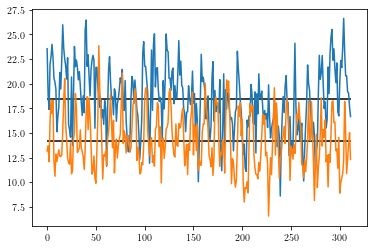

In [57]:
min_sig=25
max_sig=-20
plt.plot(AMOC_SIGMA2_yearly_means[min_sig:max_sig].loc[{"lat":54}].max(dim=["sig"])/1e6,label="lat54N")
plt.hlines(AMOC_SIGMA2_yearly_means[min_sig:max_sig].loc[{"lat":54}].max(dim=["sig"]).mean()/1e6,0,312,color="k")

plt.plot(AMOC_SIGMA2_yearly_means[min_sig:max_sig].loc[{"lat":-32}].max(dim=["sig"])/1e6,label="lat32S")
plt.hlines(AMOC_SIGMA2_yearly_means[min_sig:max_sig].loc[{"lat":-32}].max(dim=["sig"]).mean()/1e6,0,312,color="k")






In [58]:
print(AMOC_SIGMA2_yearly_means[min_sig:max_sig].loc[{"lat":54}].max(dim=["sig"]).mean()/1e6)
print(AMOC_SIGMA2_yearly_means[min_sig:max_sig].loc[{"lat":54}].interp(sig=1036.95).mean()/1e6)


print(AMOC_SIGMA2_yearly_means[min_sig:max_sig].loc[{"lat":-32}].max(dim=["sig"]).mean()/1e6)
print(AMOC_SIGMA2_yearly_means[min_sig:max_sig].loc[{"lat":-32}].max(dim=["sig"]).mean()/1e6)





<xarray.DataArray ()>
array(18.45385936)
Coordinates:
    lat      int64 54
<xarray.DataArray ()>
array(1.13059991)
Coordinates:
    lat      int64 54
    sig      float64 1.037e+03
<xarray.DataArray ()>
array(14.22241209)
Coordinates:
    lat      int64 -32
<xarray.DataArray ()>
array(14.22241209)
Coordinates:
    lat      int64 -32


In [59]:
min_sig=50
max_sig=-20
print((IPMOC_SIGMA2_yearly_means.mean(dim="time")[min_sig:max_sig].loc[{"lat":-32}]/1e6).min())
print((IPMOC_SIGMA2_yearly_means.mean(dim="time")[min_sig:max_sig].loc[{"lat":-32}]/1e6))
print(IPMOC_SIGMA2_yearly_means.sig[50:])

<xarray.DataArray ()>
array(-14.35769632)
Coordinates:
    lat      int64 -32
<xarray.DataArray (sig: 7)>
array([-14.35769632, -13.46490383, -11.00894172,  -5.67339097,
        -0.65741751,  -0.03107064,   0.        ])
Coordinates:
  * sig      (sig) float64 1.037e+03 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
    lat      int64 -32
<xarray.DataArray 'sig' (sig: 27)>
array([1037.06, 1037.08, 1037.1 , 1037.12, 1037.14, 1037.16, 1037.18, 1037.2 ,
       1037.22, 1037.24, 1037.26, 1037.28, 1037.3 , 1037.32, 1037.34, 1037.36,
       1037.38, 1037.4 , 1037.42, 1037.44, 1037.46, 1037.48, 1037.5 , 1037.6 ,
       1037.7 , 1037.8 , 1037.9 ])
Coordinates:
  * sig      (sig) float64 1.037e+03 1.037e+03 1.037e+03 ... 1.038e+03 1.038e+03


In [62]:
plot_MOC(AMOC_SIGMA2_24,"AMOC $\Psi$",atl_maxsig_array,atl_maxsig_array,plt_bot=True,min_level=14,max_level=-5,n=0)



NameError: name 'atl_maxsig_array' is not defined